<a href="https://colab.research.google.com/github/changyong93/Natural-language-processing-with-chat-bot/blob/main/%EC%B1%97%EB%B4%87_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(hotel_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRF 사용을 위한 텐서플로우 버전 조정

In [1]:
#==과 버전 사이에 띄어쓰기 없이 그대로 사용
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install git+https://www.github.com/keras-team/keras-contrib.git


     |████████████████████████████████| 109.3MB 81kB/s 
     |████████████████████████████████| 3.2MB 36.1MB/s 
     |████████████████████████████████| 491kB 38.2MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 317kB 4.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 44kB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wdpi5vvy
  Running command git clone -q h

# 사전 추가를 위한 형태소 분석기 Mecab-ko 설치

In [2]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [3]:
cd Mecab-ko-for-Google-Colab/

/content/Mecab-ko-for-Google-Colab


In [4]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 64.0MB/s 
     |████████████████████████████████| 460kB 23.7MB/s 
     |████████████████████████████████| 92kB 8.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-04-26 04:13:54--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=xxnmlm527BXoYWXlPdL3Jx54Ukc%3D&Expires=1619411572&AWSAccessKeyId=AKIA6KOSE3BNJ

# 규칙정의

의도는 총 5가지

In [5]:
#예약(예약, 평점기준 추천 등) / 변경 / 취소 / 확인 / 정보(체크인, 체크아웃, 시설 등) 

# 예약 => 호텔스 컴바인 체크인 및 아웃 날짜 기준으로 가능한 방 및 추천방 전달
# xx 지역 이용 가능한 방 있어 / xx호텔 xx지역 빙 방 있어? / 내일 xx지역 이용 가능한 방 있어?? / xx지역 평점 기준으로 방 추천해줘

# 변경 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 방 변경해줘 / xxxx호텔에 예약한 거 방 변경해줘 / xxxx호텔 예약한 거 이용 날짜 변경해줘 / xxxx번호 방 날짜 변경할래

# 취소 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 취소해줘 / xxxx호텔 예약 취소해줘 / xxxx 번호 취소할게요 / xxxx번호 취소

# 확인 => 호텔스컴바인은 가격비교 사이트로 처리 불가. 고객이 실제 이용한 결제 페이지나 해당 호텔 연락처 전달
# xxxx 번호 예약 확인해줘 / xxxx 번호 예약 확인

# 정보
# xxxx 호텔 체크인 or 체크아웃 시간 언제야 / xxxx호텔 입실 or 퇴실 시간 언제야 / xxxx호텔 입퇴실 시간 언제야 / xxxx호텔 체크인 및 체크아웃 시간 언제야
# xxxx 호텔 이용가능한 시설 뭐 있어 / xxxx호텔 반려견 동반 가능해? / xxxx호텔 서비스 뭐 있어?

개체명은 아래와 같이 규칙을 정한다

In [6]:
#규칙
"""
총 9개의 태그
SEA : 검색
HOT : 호텔명
FAC : 시설(체크인,체크아웃,서비스 등 모두 포함)
GRA : 평점
PRI : 가격
DAT : 날짜(내일, 모레, 일주일 뒤, 한달 뒤, 4월30일, 5월15일, 5/15) => 체크인 체크아웃날짜는 실제 서비스에서 고객에게 따로 입력받을 수 있도록 제작
--------------------------------------------------------------------------
*변경 취소 예약 확인 과 같은 서비스는 호텔스컴바인에서 대응불가하므로 사용 안함
CHA : 변경
CAN : 취소
CHE : 확인, 체크
RES : 예약 (불필요한 것 같음..)
"""

'\n총 9개의 태그\nSEA : 검색\nHOT : 호텔명\nFAC : 시설(체크인,체크아웃,서비스 등 모두 포함)\nGRA : 평점\nPRI : 가격\nDAT : 날짜(내일, 모레, 일주일 뒤, 한달 뒤, 4월30일, 5월15일, 5/15) => 체크인 체크아웃날짜는 실제 서비스에서 고객에게 따로 입력받을 수 있도록 제작\n--------------------------------------------------------------------------\n*변경 취소 예약 확인 과 같은 서비스는 호텔스컴바인에서 대응불가하므로 사용 안함\nCHA : 변경\nCAN : 취소\nCHE : 확인, 체크\nRES : 예약 (불필요한 것 같음..)\n'

## 호텔명 및 지역명 불러오기
- hotelscombind에서 지역별로 호텔명을 가져옴
- 호텔스컴바인은 전체 리스트가 아닌, 지정한 조건(체크인, 체크아웃, 객실수, 이용객 수)에 따라 조건이 달라짐
- 해당 데이터는 4.17~4.18 객실 1개, 이용객 2명 기준으로 각 지역별로 호텔명을 크롤링
- colab에서 selenium을 이용한 크롤링에 제한사항(사용법을 잘 모름)으로 우선 local의 jupyter notebook에서 크롤링 진행  
---
- 지역명은 각 지역(서울,서귀포 등)에서 호텔스컴바인 기준으로 가져옴
  https://www.hotelscombined.co.kr/Place/Seoul.htm

In [7]:
#단어 추가를 위해선 마지막 글자의 종성여부 판단이 필요, 관련 패키지 설치
!pip install jamo

#개체명 인식 관련 패키지 설치
!pip install seqeval

#
import os
import google #구글 드라이브 연동

#데이터 전처리
import re #정규표현식
import pandas as pd
import numpy as np
from jamo import h2j, j2hcj #종성 여부를 판단해주는 
import tqdm 
import string #변경 종목 합습 데이터 전처리(영어 알파벳 호출용)
import random #seed 지정용
from sklearn.utils import shuffle #데이터 섞기

#시각화
import matplotlib.pyplot as plt

#한국어 형태소 분류
from konlpy.tag import Mecab

#의도분류기 전처리용
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#의도분류 모델 및 개체명 인식 모델 공용
from keras.layers import Dense, Embedding
from keras.models import Sequential
from keras.models import load_model

#의도분류기 모델 생성
from keras.layers import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle #모델 저장용

#개체명 인식 모델 생성
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report #시퀀스 라벨링 평가용
os.listdir()

#개체명 인식 모델 생성
from keras import Input, Model
from keras.layers import LSTM, Bidirectional, Dropout, TimeDistributed, Conv1D, GlobalMaxPooling1D, Flatten, concatenate
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss #load_model 시 사용
from keras_contrib.metrics import crf_viterbi_accuracy #load_model 시 사용

#고객 질문 답변을 위한 크롤링
import urllib
from urllib.request import urlopen, Request
import bs4

#beautifulsoup은 XPath 표현식을 지원하지 않으므로 대체
import lxml.html
import requests

     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=0af7a34b1576b1a0659569ce7e9bab9b1e804612f9b35b5ee2c7727c3750f9c3
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [8]:
#로컬 파일 가져오기
# from google.colab import files
# myfile1 = files.upload() #hotel_list
# myfile2 = files.upload() #location_list

##구글 드라이브에 저장된 파일 활용
# data = pd.read_csv("hotel_list.csv")
# data_loc = pd.read_csv("location_list.csv")

#상기 코드가 에러날 경우, io를 활용하여 pandas module 사용
# import io
# data = pd.read_csv(io.BytesIO(myfile1['hotel_list.csv']))
# data_loc = pd.read_csv(io.BytesIO(myfile2['location_list.csv']))

#구글 드라이브 연동 및 파일 가져오기
#구글 드라이브 연동이 실패할 경우 상기 코드를 사용하여 로컬 드라이브 내의 hotel 및 location csv파일 가져오기
google.colab.drive.mount('/content/gdrive/')
data =  pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/hotel_list.csv")
data_loc =  pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/location_list.csv")

Mounted at /content/gdrive/


In [9]:
data.head()

,Unnamed: 0,지역,호텔
0,0,서울,신라스테이 광화문
1,1,서울,신라스테이 역삼
2,2,서울,글래드 여의도
3,3,서울,글래드 강남 코엑스센터
4,4,서울,신라스테이 서대문


In [10]:
data = data[["호텔","지역"]].copy()
data.shape

(3332, 2)

In [11]:
data["호텔"].nunique(),data['지역'].nunique()

(3221, 15)

In [12]:
#중복값 제거
data = data.drop_duplicates(subset = ["호텔"])
data.shape

(3221, 2)

In [13]:
hotel_list = data["호텔"].to_list()
print(hotel_list)

['신라스테이 광화문', '신라스테이 역삼', '글래드 여의도', '글래드 강남 코엑스센터', '신라스테이 서대문', '신라스테이 서초', '나인트리 프리미어 호텔 인사동', '나인트리 프리미어 호텔 명동 2', '글래드 마포', 'L7 강남 바이 롯데', '오라카이 청계산 호텔', '시그니엘 서울', '신라스테이 삼성', '인터컨티넨탈 서울 코엑스', '롯데시티호텔 명동', '호텔 안테룸 서울', '호텔 스카이파크 킹스타운 동대문', '신라스테이 마포', '라마다 서울 호텔', '서울가든호텔', '서울 신라 호텔', '롯데시티호텔 구로', '신라스테이 구로', '오라카이 대학로 호텔', '나인트리 호텔 동대문', '라마다 서울 신도림', '티마크 그랜드 호텔 명동', '페어필드 바이 메리어트 서울', '호텔 리베라 서울', '노보텔 앰배서더 서울 용산', '그랜드 인터컨티넨탈 서울 파르나스', '쉐라톤 서울 디큐브시티 호텔', '오클라우드 호텔', '롯데 호텔 월드', '라마다 앙코르 서울 마곡', '그랜드 하얏트 서울', '임피리얼 팰리스 서울', '몬드리안 서울 이태원', 'L7 홍대 바이 롯데', '메이필드 호텔 서울', '호텔 더 디자이너스 서울역점', '콘래드 서울 호텔', '롯데시티호텔 마포', '호텔 루체브릿지', '오라카이 인사동 스위트', '아리랑힐 호텔 동대문', '도미인 서울 강남', '레스케이프 호텔', '스탠포드 호텔 서울', '롯데시티호텔 김포공항', 'PJ 호텔 명동 (피제이 호텔)', '그랜드 워커힐 서울 (구, 쉐라톤 그랜드 워커힐 서울)', '노보텔 스위트 앰배서더 서울 용산', '라이즈 오토그래프 컬렉션 바이 메리어트', '홀리데이 인 익스프레스 서울 홍대', '로사나 부띠끄 비즈니스 호텔', '호텔 인 9 강남', '호텔 파크하비오', '호텔 페이토 삼성', '로얄스퀘어호텔 서울', '서머셋 팰리스 서울', '코리아나 호텔', '오크우드 프리미어 코엑스센터', '노보텔 앰배서더 서울 동대문', '호텔 엠펠리체', '프리마 

In [14]:
print(data_loc.shape)
print("*"*30)
print(data_loc.nunique())

(132, 1)
******************************
지역    108
dtype: int64


In [15]:
data_loc = data_loc.drop_duplicates()
data_loc[20:30]

,지역
20,남대문
21,4호선 혜화역
22,올림픽공원
23,2호선 삼성역
24,동대문 종합시장
25,고려대학교
26,Jamsil Sports Complex
27,청계천
28,서귀포
29,제주시 제주 국제 공항


In [16]:
data_loc.loc[data_loc["지역"]=="Jamsil Sports Complex","지역"] = "잠실종합운동장"
data_loc[20:30]

,지역
20,남대문
21,4호선 혜화역
22,올림픽공원
23,2호선 삼성역
24,동대문 종합시장
25,고려대학교
26,잠실종합운동장
27,청계천
28,서귀포
29,제주시 제주 국제 공항


In [17]:
location_list = data_loc["지역"].to_list()
print(location_list)

['서울', '인천 국제 공항', '서울 김포 국제공항', '강서구', '서초구', '강동구', '동대문구', '종로구', '은평구', '서대문구', '영등포구', '마포구', '강북구', '롯데월드', '광화문', '홍대거리', '경복궁', '북촌 한옥마을', '홍대 앞', '코엑스', '남대문', '4호선 혜화역', '올림픽공원', '2호선 삼성역', '동대문 종합시장', '고려대학교', '잠실종합운동장', '청계천', '서귀포', '제주시 제주 국제 공항', '제주 중문 관광단지', '섭지코지', '천지연폭포', '아쿠아플라넷 제주', '제주 월드컵 경기장', '서귀포 매일 올레시장', '제주 산방산탄산온천', '표선 해비치 해변', '성산항', '여수', '부산 김해 국제 공항', '대구', '무안 국제 공항', '양양', '양양 국제 공항', '낙산사', '평창', '보광 휘닉스파크', '용평 스키 리조트', '둔내자연휴양림', '제주시', '함덕 해수욕장', '제주 협재 해수욕장', '한라산 국립공원', '동문시장', '월정리 해수욕장', '탑동광장', '곽지 해수욕장', '한라산', '용두암', '이호 해변', '김녕해수욕장', '한림공원', '세화 해수욕장', '강릉', '강릉 경포대', '경포해수욕장', '주문진항', '강릉 주문진 해수욕장', '강릉 정동진 해돋이공원', '인천', '인천 을왕리 해수욕장', '월미도', '송도 컨벤시아', '센트럴파크', '인천 차이나 타운', '공항철도 운서역', '인천 1호선 인천터미널역', '공항철도인천국제공항역', '거제', '통영', '부산', '광안리 해수욕장', '해운대 해수욕장', '서면', '부산 1, 2호선 서면역', '부산 2호선 해운대역', '벡스코', '광안대교', '부산 자갈치 시장', '경부선 부산역', '국제시장', '부산대학교', '부산2호선 벡스코역', '태종대', '부산 2호선 광안역', '부산역 광장', '속초', '대포항', '속초설악파인리조트', '경주', '경주 월드 

## 학습 데이터 만들기

### 형태소 분석기 사전 추가할 데이터 정리(호텔)

In [18]:
mecab = Mecab()

In [19]:
for i in range(1000):
  print(f"[{i}번째] {hotel_list[i]} ===> {mecab.pos(hotel_list[i])}")
mecab.pos(hotel_list[0])

[0번째] 신라스테이 광화문 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('광화문', 'NNG')]
[1번째] 신라스테이 역삼 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('역삼', 'NNG')]
[2번째] 글래드 여의도 ===> [('글래드', 'NNP'), ('여의도', 'NNG')]
[3번째] 글래드 강남 코엑스센터 ===> [('글래드', 'NNP'), ('강남', 'NNP'), ('코엑스센터', 'NNP')]
[4번째] 신라스테이 서대문 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('서대문', 'NNG')]
[5번째] 신라스테이 서초 ===> [('신라', 'NNP'), ('스테이', 'NNG'), ('서초', 'NNG')]
[6번째] 나인트리 프리미어 호텔 인사동 ===> [('나', 'NP'), ('인', 'VCP+ETM'), ('트리', 'NNG'), ('프리미어', 'NNP'), ('호텔', 'NNG'), ('인사동', 'NNP')]
[7번째] 나인트리 프리미어 호텔 명동 2 ===> [('나', 'NP'), ('인', 'VCP+ETM'), ('트리', 'NNG'), ('프리미어', 'NNP'), ('호텔', 'NNG'), ('명동', 'NNG'), ('2', 'SN')]
[8번째] 글래드 마포 ===> [('글래드', 'NNP'), ('마포', 'NNG')]
[9번째] L7 강남 바이 롯데 ===> [('L', 'SL'), ('7', 'SN'), ('강남', 'NNP'), ('바이', 'NNP'), ('롯데', 'NNP')]
[10번째] 오라카이 청계산 호텔 ===> [('오라', 'IC'), ('카이', 'NNP'), ('청계산', 'NNP'), ('호텔', 'NNG')]
[11번째] 시그니엘 서울 ===> [('시그', 'NNP'), ('니엘', 'NNP'), ('서울', 'NNP')]
[12번째] 신라스테이 삼성 ===> [('신라', 'NNP'), ('스테이', 'N

[('신라', 'NNP'), ('스테이', 'NNG'), ('광화문', 'NNG')]

형태소가 부정확하게 인식하는 것에 대해서 우선 사전을 추가
- 띄어쓰기 단위로 단어를 나누고, 2글자 이상만 선택 후 사전에 추가
- 한글만

In [20]:
print(hotel_list[9])
print(re.sub(pattern="[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = hotel_list[9]))

L7 강남 바이 롯데
 강남 바이 롯데


In [21]:
words_hotel = []
for i in range(len(hotel_list)):
  hotel_name = hotel_list[i]
  hotel_name = re.sub(pattern = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = hotel_name)
  for word in hotel_name.split():
    if (len(word) >= 2) & (word not in words_hotel):
      words_hotel.append(word)


In [22]:
print("2글자 이상의 단어 개수: ", len(words_hotel))
print("-"*30)
print(words_hotel)

2글자 이상의 단어 개수:  2806
------------------------------
['신라스테이', '광화문', '역삼', '글래드', '여의도', '강남', '코엑스센터', '서대문', '서초', '나인트리', '프리미어', '호텔', '인사동', '명동', '마포', '바이', '롯데', '오라카이', '청계산', '시그니엘', '서울', '삼성', '인터컨티넨탈', '코엑스', '롯데시티호텔', '안테룸', '스카이파크', '킹스타운', '동대문', '라마다', '서울가든호텔', '신라', '구로', '대학로', '신도림', '티마크', '그랜드', '페어필드', '메리어트', '리베라', '노보텔', '앰배서더', '용산', '파르나스', '쉐라톤', '디큐브시티', '오클라우드', '월드', '앙코르', '마곡', '하얏트', '임피리얼', '팰리스', '몬드리안', '이태원', '홍대', '메이필드', '디자이너스', '서울역점', '콘래드', '루체브릿지', '스위트', '아리랑힐', '도미인', '레스케이프', '스탠포드', '김포공항', '피제이', '워커힐', '라이즈', '오토그래프', '컬렉션', '홀리데이', '익스프레스', '로사나', '부띠끄', '비즈니스', '파크하비오', '페이토', '로얄스퀘어호텔', '서머셋', '코리아나', '오크우드', '엠펠리체', '프리마', '라이브', '포레힐', '토요코인', '서울강남점', '웨스틴', '조선', '스타즈', '독산점', '비스타', '뉴브', '리즈', '딜라이트', '머큐어', '쏘도베', '어반', '플레이스', '포포인츠', '켄싱턴', '밀레니엄', '힐튼', '리버사이드', '서울역', '메이플레이스', '스위트호텔', '코트야드', '타임스퀘어', '스테이', '더파크호텔', '해밀톤', '포시즌스', '엔트라', '파크', '부티크', '그레이스리', '보타닉', '유리앤', '리센츠', '프리미엄', '가로수길', '서울영등포점', '인터시티', '아벤

### 형태소 분석기 사전 추가할 데이터 정리(지역명)

In [23]:
for i in range(len(location_list)):
  print(f"[{location_list[i]}]     ", mecab.pos(location_list[i]))

[서울]      [('서울', 'NNP')]
[인천 국제 공항]      [('인천', 'NNP'), ('국제', 'NNG'), ('공항', 'NNG')]
[서울 김포 국제공항]      [('서울', 'NNP'), ('김포', 'NNP'), ('국제공항', 'NNG')]
[강서구]      [('강서구', 'NNP')]
[서초구]      [('서초구', 'NNP')]
[강동구]      [('강동구', 'NNP')]
[동대문구]      [('동대문구', 'NNP')]
[종로구]      [('종로구', 'NNP')]
[은평구]      [('은평구', 'NNP')]
[서대문구]      [('서대문구', 'NNP')]
[영등포구]      [('영등포구', 'NNP')]
[마포구]      [('마포구', 'NNP')]
[강북구]      [('강북구', 'NNP')]
[롯데월드]      [('롯데월드', 'NNP')]
[광화문]      [('광화문', 'NNG')]
[홍대거리]      [('홍대', 'NNG'), ('거리', 'NNG')]
[경복궁]      [('경복궁', 'NNG')]
[북촌 한옥마을]      [('북촌', 'NNG'), ('한옥', 'NNG'), ('마을', 'NNG')]
[홍대 앞]      [('홍대', 'NNG'), ('앞', 'NNG')]
[코엑스]      [('코엑스', 'NNP')]
[남대문]      [('남대문', 'NNP')]
[4호선 혜화역]      [('4', 'SN'), ('호', 'NNBC'), ('선', 'NNG'), ('혜화', 'NNG'), ('역', 'NNG')]
[올림픽공원]      [('올림픽', 'NNP'), ('공원', 'NNG')]
[2호선 삼성역]      [('2', 'SN'), ('호', 'NNBC'), ('선', 'NNG'), ('삼', 'NR'), ('성역', 'NNG')]
[동대문 종합시장]      [('동대문', 'NNP'), ('종합', 'NNG'), ('시장',

In [24]:
words_location = []
for i in range(len(location_list)):
  location_name = location_list[i]
  location_name = re.sub(pattern = "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]",repl = "",string = location_name)
  for word in location_name.split():
    if (len(word) >= 2) & (word not in words_location):
      words_location.append(word)

In [25]:
print("2글자 이상의 단어 개수: ", len(words_location))
print("-"*30)
print(words_location)

2글자 이상의 단어 개수:  128
------------------------------
['서울', '인천', '국제', '공항', '김포', '국제공항', '강서구', '서초구', '강동구', '동대문구', '종로구', '은평구', '서대문구', '영등포구', '마포구', '강북구', '롯데월드', '광화문', '홍대거리', '경복궁', '북촌', '한옥마을', '홍대', '코엑스', '남대문', '호선', '혜화역', '올림픽공원', '삼성역', '동대문', '종합시장', '고려대학교', '잠실종합운동장', '청계천', '서귀포', '제주시', '제주', '중문', '관광단지', '섭지코지', '천지연폭포', '아쿠아플라넷', '월드컵', '경기장', '매일', '올레시장', '산방산탄산온천', '표선', '해비치', '해변', '성산항', '여수', '부산', '김해', '대구', '무안', '양양', '낙산사', '평창', '보광', '휘닉스파크', '용평', '스키', '리조트', '둔내자연휴양림', '함덕', '해수욕장', '협재', '한라산', '국립공원', '동문시장', '월정리', '탑동광장', '곽지', '용두암', '이호', '김녕해수욕장', '한림공원', '세화', '강릉', '경포대', '경포해수욕장', '주문진항', '주문진', '정동진', '해돋이공원', '을왕리', '월미도', '송도', '컨벤시아', '센트럴파크', '차이나', '타운', '공항철도', '운서역', '인천터미널역', '공항철도인천국제공항역', '거제', '통영', '광안리', '해운대', '서면', '서면역', '해운대역', '벡스코', '광안대교', '자갈치', '시장', '경부선', '부산역', '국제시장', '부산대학교', '부산호선', '벡스코역', '태종대', '광안역', '광장', '속초', '대포항', '속초설악파인리조트', '경주', '월드', '캘리포니아비치', '전주', '군산', '동성로', '동대구역', '엑스코']


### 형태소 분석기 사전 추가할 데이터 정리(기타)

In [26]:
etc_list = ["반려견", "미만", "체크인", "체크아웃","경포의하루"]

words_etc = []
for i in range(len(etc_list)):
  word = etc_list[i]
  word = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", repl = "", string = word)
  if len(word) >= 2:
    words_etc.append(word)
words_etc

['반려견', '미만', '체크인', '체크아웃', '경포의하루']

In [27]:
add_words = words_hotel + words_location + words_etc
print(len(add_words))

2939


### 형태소 분석기 사전 업데이트 후 재실행

In [28]:
# 사전 추가를 위한 경로 이동 => user-dic 의 nnp(일반명사)에 단어 단어 추가
%cd /content/mecab-ko-dic-2.1.1-20180720
%ls

/content/mecab-ko-dic-2.1.1-20180720
aclocal.m4      EF.csv       MAJ.csv      NorthKorea.csv     tools/
AUTHORS         EP.csv       Makefile     NP.csv             unk.def
autogen.sh*     ETM.csv      Makefile.am  NR.csv             unk.dic
ChangeLog       ETN.csv      Makefile.in  Person-actor.csv   user-dic/
char.bin        feature.def  matrix.bin   Person.csv         VA.csv
char.def        Foreign.csv  matrix.def   Place-address.csv  VCN.csv
clean*          Group.csv    missing*     Place.csv          VCP.csv
CoinedWord.csv  Hanja.csv    MM.csv       Place-station.csv  VV.csv
config.log      IC.csv       model.bin    pos-id.def         VX.csv
config.status*  Inflect.csv  model.def    Preanalysis.csv    Wikipedia.csv
configure*      INSTALL      NEWS         README             XPN.csv
configure.ac    install-sh*  NNBC.csv     rewrite.def        XR.csv
COPYING         J.csv        NNB.csv      right-id.def       XSA.csv
dicrc           left-id.def  NNG.csv      Symbol.csv         XS

In [29]:
%ls user-dic/

nnp.csv  person.csv  place.csv  README.md


In [30]:
with open("./user-dic/nnp.csv",'r') as f:
  file_data = f.readlines()

In [31]:
#h2j => 조합형 한글로 바꾼 다음
#j2hcj => 완성형 한글로 바꾸기
j2hcj(h2j(add_words[0]))

'ㅅㅣㄴㄹㅏㅅㅡㅌㅔㅇㅣ'

In [32]:
T_jamo = []
def get_jongsung_TF(sample_text):
  sample_text_list = list(sample_text)
  last_word = sample_text_list[-1]
  last_word_jamo_list = list(j2hcj(h2j(last_word)))
  last_jamo = last_word_jamo_list[-1]

  #마지막 종성이 모음일 경우 T
  jongsung_TF = "T"

  #마지막 종성이 자음일 경우, 즉 입력한 단어에 받침이 있는 경우 F
  if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']:
    jongsung_TF = "F"
  
  return jongsung_TF

In [33]:
for i in range(10):
  print(f"글자: {add_words[i]:10} 받침 유무: {get_jongsung_TF(add_words[i])}")

글자: 신라스테이      받침 유무: F
글자: 광화문        받침 유무: T
글자: 역삼         받침 유무: T
글자: 글래드        받침 유무: F
글자: 여의도        받침 유무: F
글자: 강남         받침 유무: T
글자: 코엑스센터      받침 유무: F
글자: 서대문        받침 유무: T
글자: 서초         받침 유무: F
글자: 나인트리       받침 유무: F


In [34]:
#사전 추가
with open("./user-dic/nnp.csv","r") as f:
  file_data = f.readlines()

for word in add_words:
  jongsung_TF = get_jongsung_TF(word)

  # line = f"{word},,,,NNP,*,{jongsung_TF},{word},*,*,*,*,*\n"
  
  # 사전을 새로 추가했더라도 기존과 같이 출력된 경우 ex) 반려견 => 반려, 견
  line = f"{word},,,{0},NNP,*,{jongsung_TF},{word},*,*,*,*,*\n"
  #사전 입력 시 0이 입력된 부분이 우선순위 지정
  #유사한 단어가 기존 사전에 포함된 경우 우선순위에 따라 결과가 출력됨
  
  file_data.append(line)

In [35]:
# 사전 작성
with open("./user-dic/nnp.csv","w") as f:
  for line in file_data:
    f.write(line)

In [36]:
# 사전 작성 후 다시 읽기
with open("./user-dic/nnp.csv","r") as f:
  file_new = f.readlines()
file_new

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '신라스테이,,,0,NNP,*,F,신라스테이,*,*,*,*,*\n',
 '광화문,,,0,NNP,*,T,광화문,*,*,*,*,*\n',
 '역삼,,,0,NNP,*,T,역삼,*,*,*,*,*\n',
 '글래드,,,0,NNP,*,F,글래드,*,*,*,*,*\n',
 '여의도,,,0,NNP,*,F,여의도,*,*,*,*,*\n',
 '강남,,,0,NNP,*,T,강남,*,*,*,*,*\n',
 '코엑스센터,,,0,NNP,*,F,코엑스센터,*,*,*,*,*\n',
 '서대문,,,0,NNP,*,T,서대문,*,*,*,*,*\n',
 '서초,,,0,NNP,*,F,서초,*,*,*,*,*\n',
 '나인트리,,,0,NNP,*,F,나인트리,*,*,*,*,*\n',
 '프리미어,,,0,NNP,*,F,프리미어,*,*,*,*,*\n',
 '호텔,,,0,NNP,*,T,호텔,*,*,*,*,*\n',
 '인사동,,,0,NNP,*,T,인사동,*,*,*,*,*\n',
 '명동,,,0,NNP,*,T,명동,*,*,*,*,*\n',
 '마포,,,0,NNP,*,F,마포,*,*,*,*,*\n',
 '바이,,,0,NNP,*,F,바이,*,*,*,*,*\n',
 '롯데,,,0,NNP,*,T,롯데,*,*,*,*,*\n',
 '오라카이,,,0,NNP,*,F,오라카이,*,*,*,*,*\n',
 '청계산,,,0,NNP,*,T,청계산,*,*,*,*,*\n',
 '시그니엘,,,0,NNP,*,T,시그니엘,*,*,*,*,*\n',
 '서울,,,0,NNP,*,T,서울,*,*,*,*,*\n',
 '삼성,,,0,NNP,*,T,삼성,*,*,*,*,*\n',
 '인터컨티넨탈,,,0,NNP,*,T,인터컨티넨탈,*,*,*,*,*\n',
 '코엑스,,,0,NNP,*,F,코엑스,*,*,*,*,*\n',
 '롯데시티호텔,,,0,NNP,*,T,롯데시티호텔,*,*,*,*,*\n',
 '안테룸,,,0,NNP,*,T,안테룸,*,*,

In [37]:
# 사전  추가 완료하기
%ls

aclocal.m4      EF.csv       MAJ.csv      NorthKorea.csv     tools/
AUTHORS         EP.csv       Makefile     NP.csv             unk.def
autogen.sh*     ETM.csv      Makefile.am  NR.csv             unk.dic
ChangeLog       ETN.csv      Makefile.in  Person-actor.csv   user-dic/
char.bin        feature.def  matrix.bin   Person.csv         VA.csv
char.def        Foreign.csv  matrix.def   Place-address.csv  VCN.csv
clean*          Group.csv    missing*     Place.csv          VCP.csv
CoinedWord.csv  Hanja.csv    MM.csv       Place-station.csv  VV.csv
config.log      IC.csv       model.bin    pos-id.def         VX.csv
config.status*  Inflect.csv  model.def    Preanalysis.csv    Wikipedia.csv
configure*      INSTALL      NEWS         README             XPN.csv
configure.ac    install-sh*  NNBC.csv     rewrite.def        XR.csv
COPYING         J.csv        NNB.csv      right-id.def       XSA.csv
dicrc           left-id.def  NNG.csv      Symbol.csv         XSN.csv
EC.csv          MAG.csv      NN

In [38]:
%ls tools

add-userdic.sh*  convert_for_using_store.sh*  mecab-bestn.sh*


In [39]:
!bash ./tools/add-userdic.sh

generating userdic...
nnp.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/nnp.csv ... 
done!
person.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/person.csv ... 
done!
place.csv
/content/mecab-ko-dic-2.1.1-20180720/tools/../model.def is not a binary model. reopen it as text mode...
reading /content/mecab-ko-dic-2.1.1-20180720/tools/../user-dic/place.csv ... 
done!
test -z "model.bin matrix.bin char.bin sys.dic unk.dic" || rm -f model.bin matrix.bin char.bin sys.dic unk.dic
/usr/local/libexec/mecab/mecab-dict-index -d . -o . -f UTF-8 -t UTF-8
reading ./unk.def ... 13
emitting double-array: 100% |###########################################| 
reading ./EC.csv ... 2547
reading ./VX.csv ... 125
reading ./MM.csv ... 453
reading ./XSV.csv ... 23
r

In [40]:
!make install

make[1]: Entering directory '/content/mecab-ko-dic-2.1.1-20180720'
make[1]: Nothing to be done for 'install-exec-am'.
 /bin/mkdir -p '/usr/local/lib/mecab/dic/mecab-ko-dic'
 /usr/bin/install -c -m 644 model.bin matrix.bin char.bin sys.dic unk.dic left-id.def right-id.def rewrite.def pos-id.def dicrc '/usr/local/lib/mecab/dic/mecab-ko-dic'
make[1]: Leaving directory '/content/mecab-ko-dic-2.1.1-20180720'


In [41]:
# 정상적으로 등록된 지 재확인
from konlpy.tag import Mecab

mecab = Mecab()

for i in range(30):
  print(f"[{i}번째] {hotel_list[i]} ===> {mecab.pos(hotel_list[i])}")
mecab.pos(hotel_list[0])

[0번째] 신라스테이 광화문 ===> [('신라스테이', 'NNP'), ('광화문', 'NNP')]
[1번째] 신라스테이 역삼 ===> [('신라스테이', 'NNP'), ('역삼', 'NNP')]
[2번째] 글래드 여의도 ===> [('글래드', 'NNP'), ('여의도', 'NNP')]
[3번째] 글래드 강남 코엑스센터 ===> [('글래드', 'NNP'), ('강남', 'NNP'), ('코엑스센터', 'NNP')]
[4번째] 신라스테이 서대문 ===> [('신라스테이', 'NNP'), ('서대문', 'NNP')]
[5번째] 신라스테이 서초 ===> [('신라스테이', 'NNP'), ('서초', 'NNP')]
[6번째] 나인트리 프리미어 호텔 인사동 ===> [('나인트리', 'NNP'), ('프리미어', 'NNP'), ('호텔', 'NNP'), ('인사동', 'NNP')]
[7번째] 나인트리 프리미어 호텔 명동 2 ===> [('나인트리', 'NNP'), ('프리미어', 'NNP'), ('호텔', 'NNP'), ('명동', 'NNP'), ('2', 'SN')]
[8번째] 글래드 마포 ===> [('글래드', 'NNP'), ('마포', 'NNP')]
[9번째] L7 강남 바이 롯데 ===> [('L', 'SL'), ('7', 'SN'), ('강남', 'NNP'), ('바이', 'NNP'), ('롯데', 'NNP')]
[10번째] 오라카이 청계산 호텔 ===> [('오라카이', 'NNP'), ('청계산', 'NNP'), ('호텔', 'NNP')]
[11번째] 시그니엘 서울 ===> [('시그니엘', 'NNP'), ('서울', 'NNP')]
[12번째] 신라스테이 삼성 ===> [('신라스테이', 'NNP'), ('삼성', 'NNP')]
[13번째] 인터컨티넨탈 서울 코엑스 ===> [('인터컨티넨탈', 'NNP'), ('서울', 'NNP'), ('코엑스', 'NNP')]
[14번째] 롯데시티호텔 명동 ===> [('롯데시티호텔', 'NNP'), ('명동', '

[('신라스테이', 'NNP'), ('광화문', 'NNP')]

### 예약 종목 학습 데이터 만들기

In [ ]:
# price_list =[] #price가 없을 경우에 약 3만개의 질문이 생성되는데, price가 여러개일 경우  질문이 백만개 단위로 생성됨, 우선 하나의 값만 적용
# for price in range(100000, 210000, 10000):
#   price_won = f"{price}원"
#   price_list.append(price)
#   price_list.append(price_won)

price_list = ["100000", "100000원"]
print(price_list)

['100000', '100000원']


In [ ]:
def question_generator(hotel_list, location_list, price_list):
  """
  hotel_list : 호텔스컴바인의 호텔 리스트 기준으로 생성
  location_list : 호텔스컴바인의 지역별 세부 지역 혹은 명소 등을 기준으로 생성
  price_list : 100000~200000 사이를 기준으로 잡고 리스트 생성

  location_list & price_list가 없을 경우 hotel_list 기준으로만 질문 생성
  """
  question = []

  for hotel in hotel_list:
    for location in location_list:
      s1 = hotel + " " + location + " 이용 가능한 방 있어?"
      s2 = hotel + " " + location + " 빈 방 있어?"
      s3 = hotel + " " + location + " 묵을 방 있어?"
      s4 = hotel + " " + location + " 방 있어?"
      s5 = hotel + " " + location + " 이용 가능한 방"
      s6 = hotel + " " + location + " 내일 이용 가능해?"
      s7 = hotel + " " + location + " 모레 방 있어?"
      s8 = hotel + " " + location + " 이용 가능한 방 있어?"
      s9 = hotel + " " + location + " 빈 방 있어?"
      s10 = hotel + " " + location + " 묵을 방 있어?"
      s11 = hotel + " " + location + " 방 있어?"
      question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]

  for price in price_list:
    for hotel in hotel_list:
      for location in location_list:
        s1 = price + " 이하 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s2 = price + " 미만 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s3 = price + " 밑으로 " + hotel + " " + location + " 이용 가능한 방 있어?"
        s4 = price + " 아래로 " + hotel + " " + location + " 이용 가능한 방 있어?"
        question = question + [s1,s2,s3,s4]

  for location in location_list:
    s1 = location + " 방 있어?"
    s2 = location + " 이용 가능한 호텔 있어?"
    s3 = location + " 빈 방 있어?"
    s4 = location + " 빈 방 알려줘"
    s5 = location + " 평점 기준으로 추천해 줘"
    s6 = location + " 평점 높은 곳이 어디야"
    s7 = location + " 추천해줘"
    s8 = f"{price} 이하 " + location + " 평점 기준으로 추천해 줘"
    s9 = f"{price} 미만 " + location + " 평점 기준으로 추천해 줘"
    s10 = f"{price} 밑으로 " + location + " 평점 기준으로 추천해 줘"
    s11 = f"{price} 아래로 " + location + " 평점 기준으로 추천해 줘"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11]

  for price in price_list:
    for location in location_list:
      s1 = f"{price} 이하 " + location + " 평점 기준으로 추천해 줘"
      s2 = f"{price} 미만 " + location + " 평점 기준으로 추천해 줘"
      s3 = f"{price} 밑으로 " + location + " 평점 기준으로 추천해 줘"
      s4 = f"{price} 아래로 " + location + " 평점 기준으로 추천해 줘"
      question = question + [s1,s2,s3,s4]

  return question

In [ ]:
print(len(hotel_list) , len(location_list))
print(len(hotel_list)*len(location_list)*12)

3221 108
4174416


In [ ]:
# hotel_list(3221개) * location_list(108개) * 질문(s1~s12)만해도 400만개가 넘으므로 hotel_list의 일부만 선택 
# hotel_list 전체 개수의 10%
import random
select_hotel_num = int(len(hotel_list)*0.1) #644개
# select_location_list = int(len(location_list)*0.5) # 54개

random.seed(1)
hotel_list_selected = random.sample(hotel_list,select_hotel_num)
# location_list_selected = random.sample(location_list,select_location_list)

# question = question_generator(hotel_list, location_list, price_list)
# question = question_generator(hotel_list_selected, location_list_selected, price_list)
question = question_generator(hotel_list_selected, location_list, price_list)

In [ ]:
question = shuffle(question).copy()
reservation = question
len(reservation)

662796

In [ ]:
random.sample(reservation, 20)

['100000 미만 호텔 Ddk 제주 중문 관광단지 이용 가능한 방 있어?',
 '코델리아호텔 광화문 방 있어?',
 '주공공사호텔 부산 김해 국제 공항 이용 가능한 방 있어?',
 '100000 미만 CF 모텔 성서점 광안대교 이용 가능한 방 있어?',
 '호텔더그랑 남포 북촌 한옥마을 빈 방 있어?',
 '더젠틀호텔 월미도 빈 방 있어?',
 '예담펜션 통영 방 있어?',
 '부산 동래 꿈 롯데월드 이용 가능한 방',
 '100000 아래로 하얏트모텔 서대문구 이용 가능한 방 있어?',
 '이스턴엠버 호텔 인천 차이나 타운 내일 이용 가능해?',
 '100000 아래로 하운드 호텔 부산역 영등포구 이용 가능한 방 있어?',
 '송정올라호텔 한림공원 묵을 방 있어?',
 'WS 호텔 강릉 정동진 해돋이공원 빈 방 있어?',
 '100000원 이하 태양과바다 펜션 한림공원 이용 가능한 방 있어?',
 '100000원 미만 센텀프리미어호텔 탑동광장 이용 가능한 방 있어?',
 'ITW 호텔 이태원 마포구 내일 이용 가능해?',
 '100000원 이하 보넘 1957 한옥 스테이 & 호텔 통영 이용 가능한 방 있어?',
 '황금빛 펜션 청계천 이용 가능한 방',
 '해바라기 게스트하우스 잠실종합운동장 빈 방 있어?',
 '이코노미 호텔 속초점 세화 해수욕장 모레 방 있어?']

In [ ]:
reservation[-1]

'100000원 밑으로 로얄스퀘어호텔 서울 동대구역 이용 가능한 방 있어?'

In [ ]:
test_result = question_generator(["신라 호텔"], ["서울 지역"], ["100000원"])
test_result

['신라 호텔 서울 지역 이용 가능한 방 있어?',
 '신라 호텔 서울 지역 빈 방 있어?',
 '신라 호텔 서울 지역 묵을 방 있어?',
 '신라 호텔 서울 지역 방 있어?',
 '신라 호텔 서울 지역 이용 가능한 방',
 '신라 호텔 서울 지역 내일 이용 가능해?',
 '신라 호텔 서울 지역 모레 방 있어?',
 '신라 호텔 서울 지역 이용 가능한 방 있어?',
 '신라 호텔 서울 지역 빈 방 있어?',
 '신라 호텔 서울 지역 묵을 방 있어?',
 '신라 호텔 서울 지역 방 있어?',
 '100000원 이하 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 미만 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 밑으로 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '100000원 아래로 신라 호텔 서울 지역 이용 가능한 방 있어?',
 '서울 지역 방 있어?',
 '서울 지역 이용 가능한 호텔 있어?',
 '서울 지역 빈 방 있어?',
 '서울 지역 빈 방 알려줘',
 '서울 지역 평점 기준으로 추천해 줘',
 '서울 지역 평점 높은 곳이 어디야',
 '서울 지역 추천해줘',
 '100000원 이하 서울 지역 평점 기준으로 추천해 줘',
 '100000원 미만 서울 지역 평점 기준으로 추천해 줘',
 '100000원 밑으로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 아래로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 이하 서울 지역 평점 기준으로 추천해 줘',
 '100000원 미만 서울 지역 평점 기준으로 추천해 줘',
 '100000원 밑으로 서울 지역 평점 기준으로 추천해 줘',
 '100000원 아래로 서울 지역 평점 기준으로 추천해 줘']

In [ ]:
tokenized_test_result = []
for sample_keyword_question in test_result:
  tokenized_test_result.append(mecab.morphs(sample_keyword_question))

In [ ]:
for sample in tokenized_test_result:
  print(sample)

['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '빈', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '묵', '을', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방']
['신라', '호텔', '서울', '지역', '내일', '이용', '가능', '해', '?']
['신라', '호텔', '서울', '지역', '모레', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '빈', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '묵', '을', '방', '있', '어', '?']
['신라', '호텔', '서울', '지역', '방', '있', '어', '?']
['100000', '원', '이하', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '미만', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '밑', '으로', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['100000', '원', '아래', '로', '신라', '호텔', '서울', '지역', '이용', '가능', '한', '방', '있', '어', '?']
['서울', '지역', '방', '있', '어', '?']
['서울', '지역', '이용', '가능', '한', '호텔', '있', '어', '?']

향후 필요한 키워드와 불필요한 키워드를 분류해야 하므로 현재 인텐트의 불필요한 단어를 정리

In [ ]:
reservation_stopwords_list \
 = set([item for sample in tokenized_test_result for item in sample if item not in ['신라','호텔','내일','모레','주','수요일','서울','평점','추천','100000']])
print(reservation_stopwords_list)

{'원', '한', '가능', '이용', '묵', '로', '?', '높', '알려줘', '어', '야', '은', '으로', '방', '빈', '해', '곳', '이하', '이', '지역', '아래', '을', '밑', '미만', '줘', '기준', '있', '어디'}


In [ ]:
reservation_data = {'question' : reservation, 'intent' : "예약"}
reservation_df = pd.DataFrame(reservation_data, columns = ["question","intent"])

In [ ]:
reservation_df.sample(20)

,question,intent
35622,하라모텔 대포항 빈 방 있어?,예약
477920,모닝블루펜션 국제시장 방 있어?,예약
528451,더젠틀호텔 제주 월드컵 경기장 내일 이용 가능해?,예약
357810,놈 모텔 고려대학교 이용 가능한 방 있어?,예약
564576,100000 미만 호텔 엔트라 공항철도 운서역 이용 가능한 방 있어?,예약
396182,썸타임모텔 한림공원 내일 이용 가능해?,예약
53826,100000 미만 호텔리베 2호선 삼성역 이용 가능한 방 있어?,예약
360183,위너스 용두암 빈 방 있어?,예약
656265,제주 휴 리조트 부산 자갈치 시장 방 있어?,예약
524524,인터시티 서울 호텔 잠실종합운동장 이용 가능한 방,예약


### 변경 종목 학습 데이터 만들기

In [ ]:
#예약번호 OR 확인번호 임시 지정
number_list = [str(number) for number in range(210401,210431)]

alphabet = list(string.ascii_uppercase)

reservation_number_list = []
for number in number_list:
  for str1 in alphabet:
    for str2 in alphabet:
      reservation_number_list.append(number + str1 + str2)

print(len(reservation_number_list))
print("*"*100)
print(reservation_number_list[:20])

20280
****************************************************************************************************
['210401AA', '210401AB', '210401AC', '210401AD', '210401AE', '210401AF', '210401AG', '210401AH', '210401AI', '210401AJ', '210401AK', '210401AL', '210401AM', '210401AN', '210401AO', '210401AP', '210401AQ', '210401AR', '210401AS', '210401AT']


In [ ]:
def question_generator(reservation_number_list):
  question = []
  
  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 변경해줘"
    s2 = reservation_number + " 예약 변경할래"
    s3 = reservation_number + " 예약 변경"
    s4 = reservation_number + " 예약 바꿔줘"
    s5 = reservation_number + " 예약 바꿀래"
    s6 = reservation_number + " 날짜 변경해줘"
    s7 = reservation_number + " 날짜 바꿔할래"
    s8 = reservation_number + " 날짜 변경"
    s9 = reservation_number + " 날짜 바꿔줘"
    s10 = reservation_number + " 방 바꿀래"
    s11 = reservation_number + " 방 변경해줘"
    s12 = reservation_number + " 방 바꿔할래"
    s13 = reservation_number + " 방 변경"
    s14 = reservation_number + " 방 바꿔줘"
    s15 = reservation_number + " 방 바꿀래"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15]
  
  return question
question = question_generator(reservation_number_list)

In [ ]:
question = shuffle(question).copy()
change = question.copy()
len(change)

304200

In [ ]:
random.sample(change, 20)

['210411LM 방 변경해줘',
 '210421CV 날짜 변경',
 '210414ID 날짜 변경',
 '210409AH 방 바꿀래',
 '210419VE 날짜 변경',
 '210421YS 예약 바꿔줘',
 '210412VD 방 바꿀래',
 '210417NK 날짜 바꿔할래',
 '210403CL 예약 바꿔줘',
 '210412ZW 방 변경해줘',
 '210405ZL 방 바꿔할래',
 '210423LZ 방 바꿀래',
 '210402ES 예약 바꿔줘',
 '210424UK 예약 바꿔줘',
 '210410GT 방 바꿔줘',
 '210423BR 방 변경해줘',
 '210417ZJ 방 변경',
 '210407CU 방 바꿀래',
 '210407CO 예약 변경해줘',
 '210413RQ 예약 변경해줘']

In [ ]:
question_list = question_generator(["210418AA"])
question_list

['210418AA 예약 변경해줘',
 '210418AA 예약 변경할래',
 '210418AA 예약 변경',
 '210418AA 예약 바꿔줘',
 '210418AA 예약 바꿀래',
 '210418AA 날짜 변경해줘',
 '210418AA 날짜 바꿔할래',
 '210418AA 날짜 변경',
 '210418AA 날짜 바꿔줘',
 '210418AA 방 바꿀래',
 '210418AA 방 변경해줘',
 '210418AA 방 바꿔할래',
 '210418AA 방 변경',
 '210418AA 방 바꿔줘',
 '210418AA 방 바꿀래']

In [ ]:
tokenized_test_result = []
for sample_keyword_question in question_list:
  tokenized_test_result.append(mecab.morphs(sample_keyword_question))
tokenized_test_result

[['210418', 'AA', '예약', '변경', '해', '줘'],
 ['210418', 'AA', '예약', '변경', '할래'],
 ['210418', 'AA', '예약', '변경'],
 ['210418', 'AA', '예약', '바꿔', '줘'],
 ['210418', 'AA', '예약', '바꿀', '래'],
 ['210418', 'AA', '날짜', '변경', '해', '줘'],
 ['210418', 'AA', '날짜', '바꿔', '할래'],
 ['210418', 'AA', '날짜', '변경'],
 ['210418', 'AA', '날짜', '바꿔', '줘'],
 ['210418', 'AA', '방', '바꿀', '래'],
 ['210418', 'AA', '방', '변경', '해', '줘'],
 ['210418', 'AA', '방', '바꿔', '할래'],
 ['210418', 'AA', '방', '변경'],
 ['210418', 'AA', '방', '바꿔', '줘'],
 ['210418', 'AA', '방', '바꿀', '래']]

In [ ]:
tokens = [mecab.morphs(number) for number in reservation_number_list]
add_stopwords = list(set(word for token in tokens for word in token))

# not_stopwords = ["변경","바꿀","바꿔"]
not_stopwords = [] # 변경, 취소, 확인 등은 실제로 호텔스컴바인에선 수행 불가능하고, 결제 사이트 혹은 호텔에서 직접 확인해야 하므로 모두 불용어처리

change_stopwords_list = list(set([word for sample in tokenized_test_result for word in sample if word not in not_stopwords]))
change_stopwords_list = list(set(change_stopwords_list + add_stopwords))
print("변경 종목 불필요 단어 개수: ",len(change_stopwords_list))
print(change_stopwords_list[:20])

변경 종목 불필요 단어 개수:  716
['QR', 'UA', 'GP', 'UL', 'QN', 'MK', 'BB', 'AW', 'YO', 'KQ', 'LY', 'RC', 'NF', 'WB', 'RL', 'TC', 'TR', 'TQ', 'NJ', 'UB']


In [ ]:
change_data = {'question' : change, 'intent' : '변경'}
change_df = pd.DataFrame(change_data,columns = ["question","intent"])
change_df.sample(20)

,question,intent
219116,210404OD 방 바꿔할래,변경
182378,210430TQ 방 바꿀래,변경
193141,210426MS 날짜 변경해줘,변경
50373,210428UU 방 변경해줘,변경
278070,210411JO 날짜 변경,변경
154089,210421BY 방 바꿔줘,변경
291649,210407LI 방 바꿀래,변경
44763,210424FM 방 바꿔줘,변경
5431,210403CR 방 변경해줘,변경
152127,210416LV 방 바꿀래,변경


### 취소 종목 학습 데이터 만들기

In [ ]:
def question_generator(reservation_number_list):
  question = []
  
  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 취소해줘"
    s2 = reservation_number + " 예약 취소할래"
    s3 = reservation_number + " 예약 취소"
    s4 = reservation_number + " 예약 취소할게"
    s5 = reservation_number + " 취소해줘"
    s6 = reservation_number + " 취소할래"
    s7 = reservation_number + " 취소"
    s8 = reservation_number + " 취소할게"
    s9 = reservation_number + " 취소할게요"
    s10 = reservation_number + " 취소해주세요"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10]
  
  return question
question = question_generator(reservation_number_list)

In [ ]:
question = shuffle(question).copy()
cancellation = question
len(cancellation)

202800

In [ ]:
random.sample(cancellation,20)

['210424AO 예약 취소해줘',
 '210413XV 취소해줘',
 '210407QZ 취소할게',
 '210417KQ 예약 취소할게',
 '210403SZ 예약 취소할래',
 '210407FA 예약 취소할래',
 '210422MJ 예약 취소',
 '210401WD 취소해주세요',
 '210405FO 예약 취소',
 '210403KM 취소할래',
 '210408GH 예약 취소',
 '210420DX 취소',
 '210428LV 취소해주세요',
 '210427QQ 취소해주세요',
 '210423LG 취소할래',
 '210412IB 취소할게요',
 '210410SD 예약 취소',
 '210414WR 예약 취소할게',
 '210416HD 취소해줘',
 '210405MF 취소해주세요']

In [ ]:
cancellation_list = question_generator([reservation_number_list[0]])
cancellation_list

['210401AA 예약 취소해줘',
 '210401AA 예약 취소할래',
 '210401AA 예약 취소',
 '210401AA 예약 취소할게',
 '210401AA 취소해줘',
 '210401AA 취소할래',
 '210401AA 취소',
 '210401AA 취소할게',
 '210401AA 취소할게요',
 '210401AA 취소해주세요']

In [ ]:
tokenized_test_result = []

tokenized_test_result = [mecab.morphs(sample) for sample in cancellation_list]
tokenized_test_result

[['210401', 'AA', '예약', '취소', '해', '줘'],
 ['210401', 'AA', '예약', '취소', '할래'],
 ['210401', 'AA', '예약', '취소'],
 ['210401', 'AA', '예약', '취소', '할', '게'],
 ['210401', 'AA', '취소', '해', '줘'],
 ['210401', 'AA', '취소', '할래'],
 ['210401', 'AA', '취소'],
 ['210401', 'AA', '취소', '할', '게'],
 ['210401', 'AA', '취소', '할게요'],
 ['210401', 'AA', '취소', '해', '주', '세요']]

In [ ]:
not_stopwords = [] # 변경, 취소, 확인 등은 실제로 호텔스컴바인에선 수행 불가능하고, 결제 사이트 혹은 호텔에서 직접 확인해야 하므로 모두 불용어처리

cancellcation_stopwords_list = list(set(word for sample in tokenized_test_result for word in sample if word not in not_stopwords))
cancellcation_stopwords_list = list(cancellcation_stopwords_list + add_stopwords)
print("cancellation 불필요 단어 개수: ", len(cancellcation_stopwords_list))
print(cancellcation_stopwords_list[:20])

cancellation 불필요 단어 개수:  718
['게', '해', '줘', '할게요', '취소', '210401', '예약', '세요', '할', '주', '할래', 'AA', 'QR', 'UA', 'GP', 'UL', 'QN', 'MK', 'BB', 'AW']


In [ ]:
cancellation_data = {"question" : question, "intent" : "취소"}
cancellation_df = pd.DataFrame(cancellation_data, columns = ["question","intent"])
cancellation_df.sample(20)

,question,intent
52052,210415QV 취소할게요,취소
156436,210422FD 취소할래,취소
6881,210401WB 예약 취소할래,취소
148373,210421SU 취소해주세요,취소
166586,210409KM 취소,취소
196215,210413EV 취소,취소
38643,210416XR 예약 취소할게,취소
27700,210428EO 취소,취소
42781,210407OD 취소해줘,취소
79359,210408RQ 예약 취소할래,취소


### 확인 종목 학습 데이터 만들기

In [ ]:
def question_generator(reservation_number_list):
  question = []

  for reservation_number in reservation_number_list:
    s1 = reservation_number + " 예약 확인해줘"
    s2 = reservation_number + " 예약 확인"
    s3 = reservation_number + " 예약 확인해주세요"
    s4 = reservation_number + " 확인해주세요"
    s5 = reservation_number + " 예약이 잘 됐는지 확인 부탁"
    s6 = reservation_number + " 예약 체크해줘"
    question = question + [s1,s2,s3,s4,s5,s6]

  return question

In [ ]:
question = question_generator(reservation_number_list)

In [ ]:
question = shuffle(question).copy()
confirmation = question
len(confirmation)

121680

In [ ]:
random.sample(confirmation,20)

['210409PI 예약이 잘 됐는지 확인 부탁',
 '210423VH 예약 확인해주세요',
 '210420VV 예약 확인',
 '210427IS 확인해주세요',
 '210429LM 예약 체크해줘',
 '210427NF 예약 확인',
 '210418QS 예약 체크해줘',
 '210411CB 예약 체크해줘',
 '210427DX 예약이 잘 됐는지 확인 부탁',
 '210422TX 확인해주세요',
 '210406GL 예약이 잘 됐는지 확인 부탁',
 '210404PD 예약이 잘 됐는지 확인 부탁',
 '210428KA 예약이 잘 됐는지 확인 부탁',
 '210430HW 예약 확인',
 '210426NE 예약 확인',
 '210417MU 예약이 잘 됐는지 확인 부탁',
 '210414IF 예약이 잘 됐는지 확인 부탁',
 '210423NI 확인해주세요',
 '210407XK 예약 확인',
 '210429IG 예약 체크해줘']

In [ ]:
question_list = question_generator([reservation_number_list[0]])
question_list

['210401AA 예약 확인해줘',
 '210401AA 예약 확인',
 '210401AA 예약 확인해주세요',
 '210401AA 확인해주세요',
 '210401AA 예약이 잘 됐는지 확인 부탁',
 '210401AA 예약 체크해줘']

In [ ]:
tokenized_test_result = [mecab.morphs(sample) for sample in question_list]
tokenized_test_result

[['210401', 'AA', '예약', '확인', '해', '줘'],
 ['210401', 'AA', '예약', '확인'],
 ['210401', 'AA', '예약', '확인', '해', '주', '세요'],
 ['210401', 'AA', '확인', '해', '주', '세요'],
 ['210401', 'AA', '예약', '이', '잘', '됐', '는지', '확인', '부탁'],
 ['210401', 'AA', '예약', '체크', '해', '줘']]

In [ ]:
not_stopwords = ["확인", "체크"]
not_stopwords = [] # 변경, 취소, 확인 등은 실제로 호텔스컴바인에선 수행 불가능하고, 결제 사이트 혹은 호텔에서 직접 확인해야 하므로 모두 불용어처리

confirmation_stopwords_list = list(set(word for tokens in tokenized_test_result for word in tokens if word not in not_stopwords))
confirmation_stopwords_list = list(set(confirmation_stopwords_list + add_stopwords))
print("확인 종목 불필요 단어 개수: ",len(confirmation_stopwords_list))
print(confirmation_stopwords_list[:20])

확인 종목 불필요 단어 개수:  718
['QR', 'UA', 'GP', 'UL', 'QN', 'MK', 'BB', 'AW', 'YO', 'KQ', 'LY', 'RC', 'NF', 'WB', 'RL', 'TC', 'TR', 'TQ', 'NJ', 'UB']


In [ ]:
confirmation_data = {"question" : confirmation, "intent" : "확인"}
confirmation_df = pd.DataFrame(confirmation_data, columns = ["question","intent"])
confirmation_df.sample(20)

,question,intent
49640,210421ZS 예약 체크해줘,확인
64747,210426TP 예약 체크해줘,확인
42595,210429JK 예약 확인해줘,확인
8226,210412JM 예약 확인해주세요,확인
60474,210426RT 확인해주세요,확인
81974,210405RX 확인해주세요,확인
107262,210418ZY 확인해주세요,확인
22036,210404NX 예약이 잘 됐는지 확인 부탁,확인
111711,210427KE 확인해주세요,확인
107496,210414OO 예약 확인해주세요,확인


### 정보 종목 학습 데이터 만들기
---
체크인, 체크아웃, 시설, 반려견, 서비스 등

In [ ]:
def question_generator(hotel_list):
  question = []

  #호텔 기준
  for temp in hotel_list:
    s1 = temp + " " + "체크인 시간 언제야"
    s2 = temp + " " + "체크인 시간 알려줘"
    s3 = temp + " " + "입실 시간 언제야"
    s4 = temp + " " + "언제 입실 가능해?"
    s5 = temp + " " + "체크아웃 시간 언제야"
    s6 = temp + " " + "체크아웃 시간 알려줘"
    s7 = temp + " " + "퇴실 시간 언제야"
    s8 = temp + " " + "퇴실 언제까지야?"
    s9 = temp + " " + "이용 가능한 시설 뭐 있어?"
    s10 = temp + " " + "반려견 동반 가능해?"
    s11 = temp + " " + "서비스 뭐 있어?"
    s12 = temp + " " + "서비스 알려줘"
    s13 = temp + " " + "어떤 활동이 가능해?"
    question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13]

  # #hotel + location
  # for location in location_list:
  #   for temp in hotel_list:
  #     s1 = temp + " " + location + " " + "체크인 시간 언제야"
  #     s2 = temp + " " + location + " " + "체크인 시간 알려줘"
  #     s3 = temp + " " + location + " " + "입실 시간 언제야"
  #     s4 = temp + " " + location + " " + "언제 입실 가능해?"
  #     s5 = temp + " " + location + " " + "체크아웃 시간 언제야"
  #     s6 = temp + " " + location + " " + "체크아웃 시간 알려줘"
  #     s7 = temp + " " + location + " " + "퇴실 시간 언제야"
  #     s8 = temp + " " + location + " " + "퇴실 언제까지야?"
  #     s9 = temp + " " + location + " " + "이용 가능한 시설 뭐 있어?"
  #     s10 = temp + " " + location + " " + "반려견 동반 가능해?"
  #     s11 = temp + " " + location + " " + "서비스 뭐 있어?"
  #     s12 = temp + " " + location + " " + "서비스 알려줘"
  #     s13 = temp + " " + location + " " + "어떤 활동이 가능해?"
  #     question = question + [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13]

  return question

In [ ]:
question = question_generator(hotel_list_selected)

In [ ]:
question = shuffle(question)
information = question.copy()
len(information)

4186

In [ ]:
question_list = question_generator([hotel_list[0]])
question_list

['신라스테이 광화문 체크인 시간 언제야',
 '신라스테이 광화문 체크인 시간 알려줘',
 '신라스테이 광화문 입실 시간 언제야',
 '신라스테이 광화문 언제 입실 가능해?',
 '신라스테이 광화문 체크아웃 시간 언제야',
 '신라스테이 광화문 체크아웃 시간 알려줘',
 '신라스테이 광화문 퇴실 시간 언제야',
 '신라스테이 광화문 퇴실 언제까지야?',
 '신라스테이 광화문 이용 가능한 시설 뭐 있어?',
 '신라스테이 광화문 반려견 동반 가능해?',
 '신라스테이 광화문 서비스 뭐 있어?',
 '신라스테이 광화문 서비스 알려줘',
 '신라스테이 광화문 어떤 활동이 가능해?']

In [ ]:
tokenized_test_result = [mecab.morphs(sample) for sample in question_list]
tokenized_test_result

[['신라스테이', '광화문', '체크인', '시간', '언제', '야'],
 ['신라스테이', '광화문', '체크인', '시간', '알려줘'],
 ['신라스테이', '광화문', '입실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '언제', '입실', '가능', '해', '?'],
 ['신라스테이', '광화문', '체크아웃', '시간', '언제', '야'],
 ['신라스테이', '광화문', '체크아웃', '시간', '알려줘'],
 ['신라스테이', '광화문', '퇴실', '시간', '언제', '야'],
 ['신라스테이', '광화문', '퇴실', '언제', '까지', '야', '?'],
 ['신라스테이', '광화문', '이용', '가능', '한', '시설', '뭐', '있', '어', '?'],
 ['신라스테이', '광화문', '반려견', '동반', '가능', '해', '?'],
 ['신라스테이', '광화문', '서비스', '뭐', '있', '어', '?'],
 ['신라스테이', '광화문', '서비스', '알려줘'],
 ['신라스테이', '광화문', '어떤', '활동', '이', '가능', '해', '?']]

In [ ]:
not_stopwords = ["신라스테이","광화문","서울","체크","인","입실","체크아웃","퇴실","시설","반려","견","서비스","활동","반려견"]
information_stopwords_list = list(set(word for tokens in tokenized_test_result for word in tokens if word not in not_stopwords))
print("정보 종목 불필요 단어 개수: ",len(information_stopwords_list))
print(information_stopwords_list)

정보 종목 불필요 단어 개수:  17
['해', '한', '어떤', '시간', '가능', '이용', '어', '체크인', '이', '?', '야', '언제', '까지', '뭐', '있', '알려줘', '동반']


In [ ]:
information_data = {"question" : information, "intent" : "정보"}
information_df = pd.DataFrame(information_data, columns = ["question","intent"])
information_df.sample(20)

,question,intent
428,블루밍펜션 서비스 알려줘,정보
1771,선트리 관광호텔 반려견 동반 가능해?,정보
2773,369모텔 체크인 시간 알려줘,정보
1837,L7 명동 바이 롯데 어떤 활동이 가능해?,정보
3973,더파크호텔 서울 이용 가능한 시설 뭐 있어?,정보
264,소울모텔 반려견 동반 가능해?,정보
4101,굿스테이 잉카 모텔 어떤 활동이 가능해?,정보
4073,에이치에비뉴 호텔 성신여대 체크아웃 시간 언제야,정보
628,하이스트릿 게스트하우스 입실 시간 언제야,정보
1065,비앤엘 모텔 체크아웃 시간 알려줘,정보


### 데이터 통합

In [ ]:
final_df = information_df.copy()

In [ ]:
len(final_df)

4186

In [ ]:
final_df = final_df.append(reservation_df).append(change_df).append(cancellation_df).append(confirmation_df)

In [ ]:
len(final_df)

1295662

In [ ]:
final_df = shuffle(final_df).reset_index(drop=True)

In [ ]:
print("final_df의 shape: ",final_df.shape)
final_df[:20]

final_df의 shape:  (1295662, 2)


,question,intent
0,210425LA 날짜 바꿔할래,변경
1,하라모텔 부산 자갈치 시장 묵을 방 있어?,예약
2,210414TP 방 변경,변경
3,100000원 아래로 369모텔 월미도 이용 가능한 방 있어?,예약
4,210402FW 취소할게요,취소
5,모스크 용두암 방 있어?,예약
6,100000 밑으로 G 게스트하우스 이태원 인 서울 군산 이용 가능한 방 있어?,예약
7,하이스트릿 게스트하우스 부산 빈 방 있어?,예약
8,100000원 미만 에이치에비뉴 호텔 성신여대 경주 이용 가능한 방 있어?,예약
9,태양의바다 펜션 롯데월드 묵을 방 있어?,예약


### 데이터 저장

In [ ]:
path = '../gdrive/MyDrive/Colab Notebooks/'
# os.listdir(path)

In [ ]:
final_df.to_csv(path+'intent_data.csv',index = False)

In [ ]:
final_df = pd.read_csv(path+"intent_data.csv")

## 의도 분류 모델 만들기

### 레이블에 대한 전처리

In [42]:
idx_encode = LabelEncoder()

#final_df가 있는 경우
try: 
  print("final_df 변수 데이터가 존재합니다")
  idx_encode.fit(final_df["intent"].to_list())

#재실행하여 final_df가 없는 경우
except: 
  print("final_df 변수에 할당된 데이터가 없으므로 intent_data.csv 파일을 불러오겠습니다.")
  path = '../gdrive/MyDrive/Colab Notebooks/'
  final_df = pd.read_csv(path + "intent_data.csv")
  idx_encode.fit(final_df["intent"].to_list())

final_df 변수 데이터가 존재합니다
final_df 변수에 할당된 데이터가 없으므로 intent_data.csv 파일을 불러오겠습니다.


In [43]:
label_data = idx_encode.transform(final_df["intent"]) #고유한 정수로 변환
label_data[:10]

array([0, 1, 0, 1, 3, 1, 1, 1, 1, 1])

In [44]:
label_idx = dict(zip(list(idx_encode.classes_),list(idx_encode.transform(idx_encode.classes_))))
label_idx

{'변경': 0, '예약': 1, '정보': 2, '취소': 3, '확인': 4}

In [45]:
idx_label = {idx : label for label, idx in label_idx.items()}
idx_label

{0: '변경', 1: '예약', 2: '정보', 3: '취소', 4: '확인'}

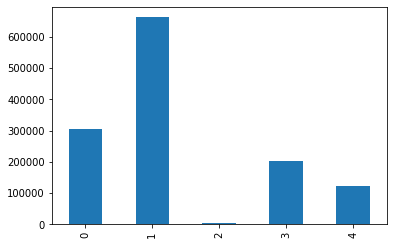

In [46]:
pd.Series(label_data).value_counts().sort_index().plot.bar()

In [47]:
intent_label_size = len(idx_label)
intent_label_size

5

### 의도 데이터에 대한 전처리

In [48]:
data_X =  [mecab.morphs(sentence) for sentence in final_df["question"]]
data_X[:3]


[['210425', 'LA', '날짜', '바꿔', '할래'],
 ['하라모텔', '부산', '자갈치', '시장', '묵', '을', '방', '있', '어', '?'],
 ['210414', 'TP', '방', '변경']]

질문 최대 길이:  24
질문 평균 길이:  8.27721813250678


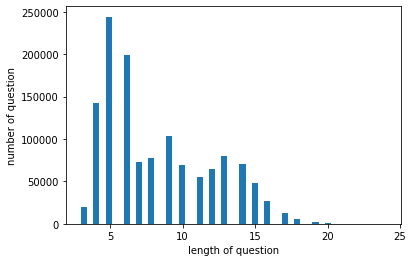

In [49]:
print("질문 최대 길이: ", max(len(sentence) for sentence in data_X))
print("질문 평균 길이: ", np.mean([len(sentence) for sentence in data_X]))
plt.hist([len(sentence) for sentence in data_X], bins = 50)
plt.xlabel("length of question")
plt.ylabel("number of question")
plt.show()

In [50]:
max_len = max(len(sentence) for sentence in data_X)
max_len

24

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_X)

In [52]:
X_data = tokenizer.texts_to_sequences(data_X)
X_data[:5]

[[50, 622, 20, 16, 17],
 [260, 34, 112, 103, 27, 28, 1, 3, 4, 2],
 [51, 623, 1, 14],
 [9, 15, 22, 23, 261, 36, 219, 6, 5, 7, 1, 3, 4, 2],
 [52, 624, 12, 83]]

In [53]:
X_data = pad_sequences(sequences=X_data, maxlen=max_len)
X_data[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  50, 622,  20,  16,  17],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 260,  34, 112, 103,  27,  28,   1,   3,   4,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  51, 623,   1,  14],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   9,  15,  22,
         23, 261,  36, 219,   6,   5,   7,   1,   3,   4,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  52, 624,  12,  83]],
      dtype=int32)

### 학습 데이터와 테스트 데이터 분리

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_data, label_data, test_size = 0.2, random_state = 1)

### 원핫 인코딩

In [55]:
y_train = to_categorical(y_train, num_classes=intent_label_size)
y_test = to_categorical(y_test, num_classes=intent_label_size)

In [56]:
y_train[:5]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [57]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1338

### 의도 분류기 학습

In [ ]:
# model = Sequential()
# model.add(Embedding(input_dim = vocab_size,output_dim = 128))
# model.add(GRU(units = 128))
# model.add(Dense(units = intent_label_size, activation = "softmax"))

model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(GRU(128))
model.add(Dense(intent_label_size, activation='softmax'))

In [ ]:
path = '../gdrive/MyDrive/Colab Notebooks/'
es = EarlyStopping(monitor = 'val_loss',patience= 4, verbose = 1, mode = 'min')
mc = ModelCheckpoint(filepath = path + "best_intent_model.h5",monitor = 'val_acc', save_best_only=True, mode = 'max',verbose = 1)

model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics = ['acc'])
history = model.fit(x = X_train, y= y_train, batch_size=128, epochs =5, callbacks = [mc,es],validation_split = 0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 829223 samples, validate on 207306 samples
Epoch 1/5
829223/829223 [==============================] - 701s 845us/step - loss: 0.0072 - acc: 0.9978 - val_loss: 8.5654e-07 - val_acc: 1.0000

Epoch 00001: val_acc improved from -inf to 1.00000, saving model to ../gdrive/MyDrive/Colab Notebooks/best_intent_model.h5
Epoch 2/5
829223/829223 [==============================] - 700s 844us/step - loss: 3.0442e-07 - acc: 1.0000 - val_loss: 1.3360e-07 - val_acc: 1.0000

Epoch 00002: val_acc did not improve from 1.00000
Epoch 3/5
829223/829223 [==============================] - 706s 851us/step - loss: 1.2202e-07 - acc: 1.0000 - val_loss: 1.1955e-07 - val_acc: 1.0000

Epoch 00003: val_acc did not improve from 1.00000
Epoch 4/5
829223/829223 [==============================] - 700s 844us/step - loss: 1.1934e-07 - acc: 1.0000 - val_loss: 1.1929e-07 - val_acc: 1.0000

Epoch 00004: val_acc did not imp

### 모델 저장 및 로드

In [58]:
# path = '../gdrive/MyDrive/Colab Notebooks/'
path = "/content/gdrive/MyDrive/Colab Notebooks/"
loaded_model = load_model(path + 'best_intent_model.h5')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
print(f"테스트 정확도: {loaded_model.evaluate(X_test,y_test)[1]*100:.2f}%")

259133/259133 [==============================] - 62s 238us/step
테스트 정확도: 100.00%


### 토크나이저 저장 및 로드

In [ ]:
#saving
# path = '../gdrive/MyDrive/Colab Notebooks/'
path = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(path+'intent_tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
#load
path = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(path+'intent_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

### 테스트

In [60]:
def predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence)
  encoded = loaded_tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  y_pred = loaded_model.predict(pad_new)
  y_pred = np.argmax(y_pred, axis = -1)
  return idx_label[y_pred[0]]


In [61]:
predict("100000 아래로 하운드호텔 기장일광점 강북구 이용 가능한 방 있어??")

'예약'

In [62]:
predict("하운드 호텔 반려견 동반해도 돼?")

'정보'

In [63]:
predict("예약 취소해줘")

'취소'

In [64]:
predict("예약 시간 바꿔줘")

'변경'

## 개체명 인식 데이터 만들기

In [ ]:
reservation_df = final_df[final_df["intent"]== "예약"].reset_index(drop=True)
change_df = final_df[final_df["intent"]== "변경"].reset_index(drop=True)
cancellation_df = final_df[final_df["intent"]== "취소"].reset_index(drop=True)
confirmation_df = final_df[final_df["intent"]== "확인"].reset_index(drop=True)
information_df = final_df[final_df["intent"]== "정보"].reset_index(drop=True)

### 예약 종목 학습 데이터 만들기

In [ ]:
reservation_df.sample(20)

,question,intent
421845,노블호텔 해운대 해수욕장 묵을 방 있어?,예약
277391,앙끄리에 펜션 경주 방 있어?,예약
485719,100000원 미만 코인호텔 영등포구 이용 가능한 방 있어?,예약
487774,100000 밑으로 주공공사호텔 김녕해수욕장 이용 가능한 방 있어?,예약
649963,스위스 그랜드 호텔 서귀포 매일 올레시장 이용 가능한 방 있어?,예약
443879,보넘 1957 한옥 스테이 & 호텔 한라산 내일 이용 가능해?,예약
213004,스타즈 호텔 명동 1호점 공항철도인천국제공항역 방 있어?,예약
412949,마리안느 호텔 용두암 방 있어?,예약
543378,100000 밑으로 24 게스트하우스 자갈치 경주 이용 가능한 방 있어?,예약
177227,경포대가는길 펜션 속초설악파인리조트 묵을 방 있어?,예약


In [ ]:
print(hotel_list)
print("*"*100)
print(location_list)

['신라스테이 광화문', '신라스테이 역삼', '글래드 여의도', '글래드 강남 코엑스센터', '신라스테이 서대문', '신라스테이 서초', '나인트리 프리미어 호텔 인사동', '나인트리 프리미어 호텔 명동 2', '글래드 마포', 'L7 강남 바이 롯데', '오라카이 청계산 호텔', '시그니엘 서울', '신라스테이 삼성', '인터컨티넨탈 서울 코엑스', '롯데시티호텔 명동', '호텔 안테룸 서울', '호텔 스카이파크 킹스타운 동대문', '신라스테이 마포', '라마다 서울 호텔', '서울가든호텔', '서울 신라 호텔', '롯데시티호텔 구로', '신라스테이 구로', '오라카이 대학로 호텔', '나인트리 호텔 동대문', '라마다 서울 신도림', '티마크 그랜드 호텔 명동', '페어필드 바이 메리어트 서울', '호텔 리베라 서울', '노보텔 앰배서더 서울 용산', '그랜드 인터컨티넨탈 서울 파르나스', '쉐라톤 서울 디큐브시티 호텔', '오클라우드 호텔', '롯데 호텔 월드', '라마다 앙코르 서울 마곡', '그랜드 하얏트 서울', '임피리얼 팰리스 서울', '몬드리안 서울 이태원', 'L7 홍대 바이 롯데', '메이필드 호텔 서울', '호텔 더 디자이너스 서울역점', '콘래드 서울 호텔', '롯데시티호텔 마포', '호텔 루체브릿지', '오라카이 인사동 스위트', '아리랑힐 호텔 동대문', '도미인 서울 강남', '레스케이프 호텔', '스탠포드 호텔 서울', '롯데시티호텔 김포공항', 'PJ 호텔 명동 (피제이 호텔)', '그랜드 워커힐 서울 (구, 쉐라톤 그랜드 워커힐 서울)', '노보텔 스위트 앰배서더 서울 용산', '라이즈 오토그래프 컬렉션 바이 메리어트', '홀리데이 인 익스프레스 서울 홍대', '로사나 부띠끄 비즈니스 호텔', '호텔 인 9 강남', '호텔 파크하비오', '호텔 페이토 삼성', '로얄스퀘어호텔 서울', '서머셋 팰리스 서울', '코리아나 호텔', '오크우드 프리미어 코엑스센터', '노보텔 앰배서더 서울 동대문', '호텔 엠펠리체', '프리마 

In [ ]:
for i in range(100):
  print(hotel_list[i])
  print(mecab.morphs(hotel_list[i]))
  print("*"*100)

신라스테이 광화문
['신라스테이', '광화문']
****************************************************************************************************
신라스테이 역삼
['신라스테이', '역삼']
****************************************************************************************************
글래드 여의도
['글래드', '여의도']
****************************************************************************************************
글래드 강남 코엑스센터
['글래드', '강남', '코엑스센터']
****************************************************************************************************
신라스테이 서대문
['신라스테이', '서대문']
****************************************************************************************************
신라스테이 서초
['신라스테이', '서초']
****************************************************************************************************
나인트리 프리미어 호텔 인사동
['나인트리', '프리미어', '호텔', '인사동']
****************************************************************************************************
나인트리 프리미어 호텔 명동 2
['나인트리', '프리미어', '호텔', '명동', '2']
*******************************

In [ ]:
hotel_list_words = list(set(word for sample in hotel_list for word in mecab.morphs(sample) if word not in reservation_stopwords_list))
location_list_words = list(set(word for sample in location_list for word in mecab.morphs(sample) if word not in reservation_stopwords_list))
search_list_words = list(set(hotel_list_words + location_list_words))
len(search_list_words)

3147

In [ ]:
tokenized_sequences = []
label_sequences = []

for sample in tqdm.notebook.tqdm(reservation_df["question"].to_list()):
  temp_sample = []
  tokenized_sample = mecab.morphs(sample)
  for word in tokenized_sample:
    try:
      if int(word) >=10000: #값이 10000보다 클 경우
        temp_sample.append("PRI")
      else:
        temp_sample.append("O") #10000 미만의 경우
    except:
      if word in search_list_words: #단어가 검색 단어 집합에 있는 경우
        temp_sample.append("SEA")
      elif word =="평점": #"평점" 인 경우
        temp_sample.append("GRA")
      else:
        temp_sample.append("O")

  
  tokenized_sequences.append(tokenized_sample)
  label_sequences.append(temp_sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
for i in range(30):
  print(f"질문[{i}]: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문[0]:  G 게스트하우스 이태원 인 서울 벡스코 묵을 방 있어?
토큰화:  ['G', '게스트하우스', '이태원', '인', '서울', '벡스코', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[1]:  바산 올레 펜션 국제시장 묵을 방 있어?
토큰화:  ['바산', '올레', '펜션', '국제', '시장', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[2]:  도도27 게스트하우스 곽지 해수욕장 방 있어?
토큰화:  ['도도', '27', '게스트하우스', '곽지', '해수욕장', '방', '있', '어', '?']
라벨링:  ['SEA', 'O', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[3]:  통영갤러리호텔 평창 이용 가능한 방
토큰화:  ['통영갤러리호텔', '평창', '이용', '가능', '한', '방']
라벨링:  ['SEA', 'SEA', 'O', 'O', 'O', 'O']
************************************************************

In [ ]:
for j  in range(len(tokenized_sequences)): # "호선" 이란 단어가 있을 경우 앞의 단어는 LOC로 변경
  tokens = tokenized_sequences[j]
  for i in range(len(tokens)-1):
    if tokens[i+1] == "호선":
      label_sequences[j][i] = label_sequences[j][i+1]

In [ ]:
for i in range(30):
  print(f"질문[{i}]: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문[0]:  G 게스트하우스 이태원 인 서울 벡스코 묵을 방 있어?
토큰화:  ['G', '게스트하우스', '이태원', '인', '서울', '벡스코', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[1]:  바산 올레 펜션 국제시장 묵을 방 있어?
토큰화:  ['바산', '올레', '펜션', '국제', '시장', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[2]:  도도27 게스트하우스 곽지 해수욕장 방 있어?
토큰화:  ['도도', '27', '게스트하우스', '곽지', '해수욕장', '방', '있', '어', '?']
라벨링:  ['SEA', 'O', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[3]:  통영갤러리호텔 평창 이용 가능한 방
토큰화:  ['통영갤러리호텔', '평창', '이용', '가능', '한', '방']
라벨링:  ['SEA', 'SEA', 'O', 'O', 'O', 'O']
************************************************************

In [ ]:
for j  in range(len(label_sequences)): #LOC 다음에 HOT가 나온 경우 LOC로 변환
  for i in range(len(label_sequences[j])-1):
    if (label_sequences[j][i] == "LOC") & (label_sequences[j][i+1] == "HOT"):
      label_sequences[j][i+1] = label_sequences[j][i]

In [ ]:
for i in range(30):
  print(f"질문[{i}]: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문[0]:  G 게스트하우스 이태원 인 서울 벡스코 묵을 방 있어?
토큰화:  ['G', '게스트하우스', '이태원', '인', '서울', '벡스코', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[1]:  바산 올레 펜션 국제시장 묵을 방 있어?
토큰화:  ['바산', '올레', '펜션', '국제', '시장', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[2]:  도도27 게스트하우스 곽지 해수욕장 방 있어?
토큰화:  ['도도', '27', '게스트하우스', '곽지', '해수욕장', '방', '있', '어', '?']
라벨링:  ['SEA', 'O', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[3]:  통영갤러리호텔 평창 이용 가능한 방
토큰화:  ['통영갤러리호텔', '평창', '이용', '가능', '한', '방']
라벨링:  ['SEA', 'SEA', 'O', 'O', 'O', 'O']
************************************************************

In [ ]:
for j  in range(len(label_sequences)): #앞 뒤의 개체명이 같을 경우 동일한 개체명으로 변경
  for i in range(1, len(label_sequences[j])-1):
    if (label_sequences[j][i-1] == label_sequences[j][i+1]) & (label_sequences[j][i]!="GRA"):
      label_sequences[j][i] = label_sequences[j][i+1]

In [ ]:
for i in range(30):
  print(f"질문[{i}]: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문[0]:  G 게스트하우스 이태원 인 서울 벡스코 묵을 방 있어?
토큰화:  ['G', '게스트하우스', '이태원', '인', '서울', '벡스코', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[1]:  바산 올레 펜션 국제시장 묵을 방 있어?
토큰화:  ['바산', '올레', '펜션', '국제', '시장', '묵', '을', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[2]:  도도27 게스트하우스 곽지 해수욕장 방 있어?
토큰화:  ['도도', '27', '게스트하우스', '곽지', '해수욕장', '방', '있', '어', '?']
라벨링:  ['SEA', 'SEA', 'SEA', 'SEA', 'SEA', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[3]:  통영갤러리호텔 평창 이용 가능한 방
토큰화:  ['통영갤러리호텔', '평창', '이용', '가능', '한', '방']
라벨링:  ['SEA', 'SEA', 'O', 'O', 'O', 'O']
**********************************************************

In [ ]:
## BI 추가
for j in range(len(label_sequences)):
# for j in range(len([tests])):
  temp_label_BI = []
  sample = label_sequences[j]
  # sample = [tests][j]

  for i in range(len(sample)):
    if i==0:
      if (sample[i] == "PRI") or (sample[i] == "SEA"):
        temp_label_BI.append("B-" + sample[i])
      
    else:
      if sample[i] != "O":
        if sample[i] == sample[i-1]:
          temp_label_BI.append("I-" + sample[i])
        else:
          temp_label_BI.append("B-" + sample[i])
      else:
        temp_label_BI.append("O")
  label_sequences[j] = temp_label_BI.copy()

In [ ]:
for i in range(30):
  print(f"질문[{i}]: ", reservation_df["question"].to_list()[i])
  print("토큰화: ", tokenized_sequences[i])
  print("라벨링: ", label_sequences[i])
  print("*"*100)

질문[0]:  G 게스트하우스 이태원 인 서울 벡스코 묵을 방 있어?
토큰화:  ['G', '게스트하우스', '이태원', '인', '서울', '벡스코', '묵', '을', '방', '있', '어', '?']
라벨링:  ['B-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[1]:  바산 올레 펜션 국제시장 묵을 방 있어?
토큰화:  ['바산', '올레', '펜션', '국제', '시장', '묵', '을', '방', '있', '어', '?']
라벨링:  ['B-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'O', 'O', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[2]:  도도27 게스트하우스 곽지 해수욕장 방 있어?
토큰화:  ['도도', '27', '게스트하우스', '곽지', '해수욕장', '방', '있', '어', '?']
라벨링:  ['B-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'O', 'O', 'O', 'O']
****************************************************************************************************
질문[3]:  통영갤러리호텔 평창 이용 가능한 방
토큰화:  ['통영갤러리호텔', '평창', '이용', '가능', '한', '방']
라벨링:  ['B-SEA', 'I-SEA', 'O', 'O', 'O', 'O']
**********************

In [ ]:
reservation_df["tokenized_sample"] = tokenized_sequences.copy()
reservation_df["ner_label"] = label_sequences.copy()

In [ ]:
reservation_df.sample(20)

,question,intent,tokenized_sample,ner_label
639000,호텔 여기어때 대구역점 대포항 이용 가능한 방 있어?,예약,"[호텔, 여기어때, 대구역점, 대포항, 이용, 가능, 한, 방, 있, 어, ?]","[B-SEA, I-SEA, I-SEA, I-SEA, O, O, O, O, O, O, O]"
631464,오색 그린야드 호텔 부산2호선 벡스코역 묵을 방 있어?,예약,"[오색, 그린야드, 호텔, 부산, 2, 호선, 벡스코역, 묵, 을, 방, 있, 어, ?]","[B-SEA, I-SEA, I-SEA, I-SEA, I-SEA, I-SEA, I-S..."
530720,곰하우스 서울 빈 방 있어?,예약,"[곰하우스, 서울, 빈, 방, 있, 어, ?]","[B-SEA, I-SEA, O, O, O, O, O]"
96056,100000 아래로 꿈에그린 펜션 월정리 해수욕장 이용 가능한 방 있어?,예약,"[100000, 아래, 로, 꿈, 에, 그린, 펜션, 월정리, 해수욕장, 이용, 가...","[B-PRI, O, O, B-SEA, I-SEA, I-SEA, I-SEA, I-SE..."
237743,하단 E모텔 인천 국제 공항 이용 가능한 방 있어?,예약,"[하단, E, 모텔, 인천, 국제, 공항, 이용, 가능, 한, 방, 있, 어, ?]","[B-SEA, I-SEA, I-SEA, I-SEA, I-SEA, I-SEA, O, ..."
281094,100000 아래로 칸 모텔 홍대거리 이용 가능한 방 있어?,예약,"[100000, 아래, 로, 칸, 모텔, 홍대거리, 이용, 가능, 한, 방, 있, ...","[B-PRI, O, O, B-SEA, I-SEA, I-SEA, O, O, O, O,..."
283647,마마스 앤 파파스 홍대 게스트하우스 경부선 부산역 내일 이용 가능해?,예약,"[마마스, 앤, 파파스, 홍대, 게스트하우스, 경부선, 부산역, 내일, 이용, 가능...","[B-SEA, I-SEA, I-SEA, I-SEA, I-SEA, I-SEA, I-S..."
636322,100000 아래로 블루보트 해운대점 부산 이용 가능한 방 있어?,예약,"[100000, 아래, 로, 블루보트, 해운대점, 부산, 이용, 가능, 한, 방, ...","[B-PRI, O, O, B-SEA, I-SEA, I-SEA, O, O, O, O,..."
7893,100000 이하 콘트 호텔 대구 이용 가능한 방 있어?,예약,"[100000, 이하, 콘트, 호텔, 대구, 이용, 가능, 한, 방, 있, 어, ?]","[B-PRI, O, B-SEA, I-SEA, I-SEA, O, O, O, O, O,..."
80199,100000 미만 정하우스 서울 이용 가능한 방 있어?,예약,"[100000, 미만, 정하우스, 서울, 이용, 가능, 한, 방, 있, 어, ?]","[B-PRI, O, B-SEA, I-SEA, O, O, O, O, O, O, O]"


### 변경 종목 학습 데이터 만들기

In [ ]:
change_df.sample(20)

,question,intent
272284,210402AS 방 바꿀래,변경
128053,210423MV 날짜 바꿔할래,변경
233902,210430KM 예약 바꿀래,변경
58875,210419FE 방 변경,변경
160580,210402HK 예약 변경,변경
290108,210425HB 예약 바꿔줘,변경
126735,210418RQ 방 바꿀래,변경
160466,210424HP 날짜 바꿔할래,변경
3990,210418KN 방 바꿀래,변경
114358,210411QN 예약 바꿔줘,변경


- 호텔스컴바인은 단순 가격비교 사이트이므로, 변경, 취소, 예약 확인과 같은 요청은 결제한 사이트, 혹은 호텔에 직접 문의해야 함
- 따라서, 변경,취소,확인 의도에서는 어느 개체명도 인식할 필요는 없음

In [ ]:
 sample = mecab.morphs(change_df["question"].to_list()[0])
 ['O' for num in range(len(sample))]
# sample

['O', 'O', 'O', 'O', 'O']

In [ ]:
tokenized_sample_data = []
ner_label_data = []
for sample in tqdm.notebook.tqdm(change_df["question"].to_list()):  
  tokenized_sample = mecab.morphs(sample).copy()
  temp_label_BI = ['O' for num in range(len(tokenized_sample))]

  tokenized_sample_data.append(tokenized_sample)
  ner_label_data.append(temp_label_BI)

change_df["tokenized_sample"] = tokenized_sample_data
change_df["ner_label"] = ner_label_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
change_df.head(20)

,question,intent,tokenized_sample,ner_label
0,210404XT 예약 변경할래,변경,"[210404, XT, 예약, 변경, 할래]","[O, O, O, O, O]"
1,210412BU 방 변경,변경,"[210412, BU, 방, 변경]","[O, O, O, O]"
2,210429BV 예약 바꿔줘,변경,"[210429, BV, 예약, 바꿔, 줘]","[O, O, O, O, O]"
3,210416ZN 방 바꿔줘,변경,"[210416, ZN, 방, 바꿔, 줘]","[O, O, O, O, O]"
4,210417IE 방 바꿔할래,변경,"[210417, IE, 방, 바꿔, 할래]","[O, O, O, O, O]"
5,210401AO 방 바꿔할래,변경,"[210401, AO, 방, 바꿔, 할래]","[O, O, O, O, O]"
6,210421XA 예약 변경할래,변경,"[210421, XA, 예약, 변경, 할래]","[O, O, O, O, O]"
7,210415EO 날짜 변경,변경,"[210415, EO, 날짜, 변경]","[O, O, O, O]"
8,210413HP 방 변경해줘,변경,"[210413, HP, 방, 변경, 해, 줘]","[O, O, O, O, O, O]"
9,210413PD 날짜 변경해줘,변경,"[210413, PD, 날짜, 변경, 해, 줘]","[O, O, O, O, O, O]"


### 취소 종목 학습 데이터 만들기
---
- 호텔스컴바인은 단순 가격비교 사이트이므로, 변경, 취소, 예약 확인과 같은 요청은 결제한 사이트, 혹은 호텔에 직접 문의해야 함
- 따라서, 변경,취소,확인 의도에서는 어느 개체명도 인식할 필요는 없음

In [ ]:
cancellation_df.sample(20)

,question,intent
144126,210422GD 취소해주세요,취소
27219,210404LF 예약 취소할래,취소
156706,210409VM 예약 취소,취소
185218,210427FX 취소할게,취소
96452,210411EN 예약 취소해줘,취소
196644,210409FC 취소할게요,취소
166527,210415FT 취소할래,취소
169477,210402HF 예약 취소할게,취소
175723,210412OQ 예약 취소할래,취소
32643,210422NM 예약 취소,취소


In [ ]:
tokenized_sample_data = []
ner_label_data = []
for sample in tqdm.notebook.tqdm(cancellation_df["question"].to_list()):
  tokenized_sample = mecab.morphs(sample)
  ner_label_BI = ['O' for num in range(len(tokenized_sample))]

  tokenized_sample_data.append(tokenized_sample)
  ner_label_data.append(ner_label_BI)

cancellation_df["tokenized_sample"] = tokenized_sample_data.copy()
cancellation_df["ner_label"] = ner_label_data.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cancellation_df.sample(20)

,question,intent,tokenized_sample,ner_label
95681,210429CI 예약 취소,취소,"[210429, CI, 예약, 취소]","[O, O, O, O]"
14568,210416VB 예약 취소해줘,취소,"[210416, VB, 예약, 취소, 해, 줘]","[O, O, O, O, O, O]"
163991,210411VX 취소,취소,"[210411, VX, 취소]","[O, O, O]"
144004,210408ZB 취소할래,취소,"[210408, ZB, 취소, 할래]","[O, O, O, O]"
11825,210420GF 예약 취소해줘,취소,"[210420, GF, 예약, 취소, 해, 줘]","[O, O, O, O, O, O]"
24507,210404PT 취소할게,취소,"[210404, PT, 취소, 할, 게]","[O, O, O, O, O]"
44902,210428US 예약 취소해줘,취소,"[210428, US, 예약, 취소, 해, 줘]","[O, O, O, O, O, O]"
176831,210407JV 예약 취소해줘,취소,"[210407, JV, 예약, 취소, 해, 줘]","[O, O, O, O, O, O]"
168601,210412JS 예약 취소할래,취소,"[210412, JS, 예약, 취소, 할래]","[O, O, O, O, O]"
165797,210414ZR 취소해주세요,취소,"[210414, ZR, 취소, 해, 주, 세요]","[O, O, O, O, O, O]"


### 확인 종목 학습 데이터 만들기
---
- 호텔스컴바인은 단순 가격비교 사이트이므로, 변경, 취소, 예약 확인과 같은 요청은 결제한 사이트, 혹은 호텔에 직접 문의해야 함
- 따라서, 변경,취소,확인 의도에서는 어느 개체명도 인식할 필요는 없음

In [ ]:
confirmation_df.sample(20)

,question,intent
15934,210418GG 예약 체크해줘,확인
33110,210415ZF 예약 확인,확인
118478,210415UH 예약 확인해줘,확인
79201,210428VG 예약 확인해줘,확인
53244,210426LH 예약 확인,확인
22649,210411ES 확인해주세요,확인
71136,210424ZF 예약 확인,확인
4210,210410BT 예약 확인,확인
68882,210408PP 예약 확인해주세요,확인
57001,210405CV 예약이 잘 됐는지 확인 부탁,확인


In [ ]:
tokenized_sample_data = []
ner_label_data = []

for sample in tqdm.notebook.tqdm(confirmation_df["question"].to_list()):
  tokenized_sample = mecab.morphs(sample)
  ner_label_BI = ['O' for num in range(len(tokenized_sample))]

  tokenized_sample_data.append(tokenized_sample)
  ner_label_data.append(ner_label_BI)

confirmation_df["tokenized_sample"] = tokenized_sample_data.copy()
confirmation_df["ner_label"] = ner_label_data.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [ ]:
confirmation_df.sample(20)

,question,intent,tokenized_sample,ner_label
94642,210405CG 예약 확인해줘,확인,"[210405, CG, 예약, 확인, 해, 줘]","[O, O, O, O, O, O]"
65758,210419TH 예약 확인,확인,"[210419, TH, 예약, 확인]","[O, O, O, O]"
26549,210422RM 예약 체크해줘,확인,"[210422, RM, 예약, 체크, 해, 줘]","[O, O, O, O, O, O]"
35352,210412GV 확인해주세요,확인,"[210412, GV, 확인, 해, 주, 세요]","[O, O, O, O, O, O]"
106161,210408NW 예약이 잘 됐는지 확인 부탁,확인,"[210408, NW, 예약, 이, 잘, 됐, 는지, 확인, 부탁]","[O, O, O, O, O, O, O, O, O]"
105408,210413NG 예약이 잘 됐는지 확인 부탁,확인,"[210413, NG, 예약, 이, 잘, 됐, 는지, 확인, 부탁]","[O, O, O, O, O, O, O, O, O]"
66965,210419NS 예약이 잘 됐는지 확인 부탁,확인,"[210419, NS, 예약, 이, 잘, 됐, 는지, 확인, 부탁]","[O, O, O, O, O, O, O, O, O]"
73368,210426NP 예약 확인,확인,"[210426, NP, 예약, 확인]","[O, O, O, O]"
5275,210419PX 예약 확인해주세요,확인,"[210419, PX, 예약, 확인, 해, 주, 세요]","[O, O, O, O, O, O, O]"
51109,210428XC 예약 확인해주세요,확인,"[210428, XC, 예약, 확인, 해, 주, 세요]","[O, O, O, O, O, O, O]"


### 정보 종목 학습 데이터 만들기

In [ ]:
information_df.sample(20)

,question,intent
78,위너스 서비스 알려줘,정보
494,화이트캐슬 펜션 서비스 알려줘,정보
7,호텔 메종 반려견 동반 가능해?,정보
1644,대구공항 소호모텔 서비스 뭐 있어?,정보
1506,아이니 하우스 체크아웃 시간 알려줘,정보
1046,씨엔블루펜션 퇴실 언제까지야?,정보
2143,벙크 게스트하우스 입실 시간 언제야,정보
2911,더 클라우드 풀앤스파 언제 입실 가능해?,정보
3388,강릉128펜션 서비스 뭐 있어?,정보
2598,더베이호텔 반려견 동반 가능해?,정보


In [ ]:
tokenized_sample_data = []
ner_label_data = []
for sample in tqdm.notebook.tqdm(information_df["question"].to_list()):
  tokenized_sample = mecab.morphs(sample).copy()
  ner_label_BI = []

  for token in tokenized_sample:
    if token in hotel_list_words:#token이 hotel_list의 형태소 집합에 있을 경우 HOT 입력
      ner_label_BI.append("HOT")
    elif token in information_stopwords_list:#token이 information_stopwords_list의 형태소 집합에 있을 경우 O 입력
      ner_label_BI.append("O")
    else:
      ner_label_BI.append("INF") # 그 외의 경우 INF 입력
  tokenized_sample_data.append(tokenized_sample)
  ner_label_data.append(ner_label_BI)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(len(tokenized_sample_data[:30])):
  print(tokenized_sample_data[i])
  print(ner_label_data[i])
  print("*"*100)

['엘루이모텔', '퇴실', '시간', '언제', '야']
['HOT', 'INF', 'HOT', 'O', 'O']
****************************************************************************************************
['스타즈', '호텔', '명동', '1', '호', '점', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['I', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['예담펜션', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['아모렉스', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
***************************************************************************************************

- "시간" 단어의 Labeling은 "O"로 변환
- "경포의하루" 단어 Labeling은 "HOT"로 변환
- O를 제외한 가장 오른쪽 Label은 INF로 변환


In [ ]:
# "시간" 토큰의 label은 모두 O로 변환 / "경포의하루" 형태소의 라벨은 "HOT"
for i in range(len(ner_label_data)):
  for j in range(len(ner_label_data[i])):
    if tokenized_sample_data[i][j] == "시간":
      ner_label_data[i][j] = "O"
    elif tokenized_sample_data[i][j] == "경포의하루":
      ner_label_data[i][j] = "HOT"

# ner_label_data = [["O" if tokenized_sample_data[i][j] == "시간" else ner_label_data[i][j] for j in range(len(ner_label_data[i]))] for i in range(len(ner_label_data))]
# ner_label_data = [["HOT" if tokenized_sample_data[i][j] == "경포의하루" else ner_label_data[i][j] for j in range(len(ner_label_data[i]))] for i in range(len(ner_label_data))]

for i in range(len(tokenized_sample_data[:30])):
  print(tokenized_sample_data[i])
  print(ner_label_data[i])
  print("*"*100)

['엘루이모텔', '퇴실', '시간', '언제', '야']
['HOT', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['스타즈', '호텔', '명동', '1', '호', '점', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['I', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['예담펜션', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['아모렉스', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************


O를 제외한 가장 오른쪽 Label은 INF로 변환

In [ ]:
for i in range(len(ner_label_data)):
  sample = ner_label_data[i].copy()

  for idx,label in enumerate(sample):
    if label != "O":
      check_num = idx
    
  ner_label_data[i][check_num] = "INF"

In [ ]:
for i in range(len(tokenized_sample_data[:30])):
  print(tokenized_sample_data[i])
  print(ner_label_data[i])
  print("*"*100)

['엘루이모텔', '퇴실', '시간', '언제', '야']
['HOT', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['스타즈', '호텔', '명동', '1', '호', '점', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['I', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['예담펜션', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['아모렉스', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************


In [ ]:
for idx,sample in enumerate(ner_label_data):
  if sample[0] !="HOT":
    print(f"[{idx}]")
    print(tokenized_sample_data[idx])
    print(sample)

[31]
['이스턴캐슬펜션', '체크인', '시간', '언제', '야']
['INF', 'O', 'O', 'O', 'O']
[67]
['해밀터펜션', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[95]
['해', '를', '여는', '펜션', '체크인', '시간', '알려줘']
['O', 'HOT', 'INF', 'INF', 'O', 'O', 'O']
[97]
['해', '를', '여는', '펜션', '퇴실', '언제', '까지', '야', '?']
['O', 'HOT', 'INF', 'HOT', 'INF', 'O', 'O', 'O', 'O']
[100]
['요요모텔', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[138]
['글라글라펜션', '체크인', '시간', '언제', '야']
['INF', 'O', 'O', 'O', 'O']
[141]
['호텔프렌치코드', '체크인', '시간', '언제', '야']
['INF', 'O', 'O', 'O', 'O']
[157]
['노비오스펜션', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[161]
['온모텔', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[172]
['호텔프렌치코드', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[175]
['라메르펜션', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[193]
['소울모텔', '체크인', '시간', '언제', '야']
['INF', 'O', 'O', 'O', 'O']
[211]
['애인호텔', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[219]
['섬마을펜션민박', '체크인', '시간', '알려줘']
['INF', 'O', 'O', 'O']
[251]
['정하우스', '체크인', '시간', '언제', '야']
['INF', 'O', '

- 해를 여는 펜션도 hotel_list에 포함되어 있으나, 토큰화 시 해, 를 로 나뉘어 불용처 처리됨
- 해 뒤에 "를"과 "여는"이 연달아 나올 경우 해의 라벨을 "HOT"로 변경

In [ ]:
for i in range(len(tokenized_sample_data)):
  sample = tokenized_sample_data[i]

  for j in range(len(tokenized_sample_data[i])-2):
    if (tokenized_sample_data[i][j:j+3] == ["해","를","여는"]) or tokenized_sample_data[i][j:j+3] == ["해","를","여"]:
      ner_label_data[i][j:j] = ["HOT"]

In [ ]:
for i in range(len(tokenized_sample_data[:30])):
  print(tokenized_sample_data[i])
  print(ner_label_data[i])
  print("*"*100)

['엘루이모텔', '퇴실', '시간', '언제', '야']
['HOT', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['스타즈', '호텔', '명동', '1', '호', '점', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['I', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************
['예담펜션', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['HOT', 'O', 'O', 'O', 'INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['아모렉스', '호텔', '언제', '입실', '가능', '해', '?']
['HOT', 'HOT', 'O', 'INF', 'O', 'O', 'O']
****************************************************************************************************


In [ ]:
ner_label_data[0]

['HOT', 'INF', 'O', 'O', 'O']

In [ ]:
for i in range(len(ner_label_data)):
  ner_label_BI = []
  for j in range(len(ner_label_data[i])):
    if (j==0) & (ner_label_data[i][j] != "O"): #첫번째 인덱스 & 라벨이 O가 아닌 토큰
      tag_temp = "B-" + ner_label_data[i][j]
      ner_label_BI.append(tag_temp)
    elif ner_label_data[i][j] != "O": # 첫번째 인덱스가 아니면서, 라벨이 O가 아닌 토큰
      if ner_label_data[i][j] != ner_label_data[i][j-1]: #이전 인덱스와 다른 경우
        tag_temp = "B-" + ner_label_data[i][j]
        ner_label_BI.append(tag_temp)
      else:
        tag_temp = "I-" + ner_label_data[i][j]
        ner_label_BI.append(tag_temp)
    else:
      ner_label_BI.append("O")
  ner_label_data[i] = ner_label_BI

In [ ]:
for i in range(len(tokenized_sample_data[:30])):
  print(tokenized_sample_data[i])
  print(ner_label_data[i])
  print("*"*100)

['엘루이모텔', '퇴실', '시간', '언제', '야']
['B-HOT', 'B-INF', 'O', 'O', 'O']
****************************************************************************************************
['스타즈', '호텔', '명동', '1', '호', '점', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['B-HOT', 'I-HOT', 'I-HOT', 'I-HOT', 'I-HOT', 'I-HOT', 'O', 'O', 'O', 'B-INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['I', '호텔', '언제', '입실', '가능', '해', '?']
['B-HOT', 'I-HOT', 'O', 'B-INF', 'O', 'O', 'O']
****************************************************************************************************
['예담펜션', '이용', '가능', '한', '시설', '뭐', '있', '어', '?']
['B-HOT', 'O', 'O', 'O', 'B-INF', 'O', 'O', 'O', 'O']
****************************************************************************************************
['아모렉스', '호텔', '언제', '입실', '가능', '해', '?']
['B-HOT', 'I-HOT', 'O', 'B-INF', 'O', 'O', 'O']
*******************************************************************

In [ ]:
information_df["tokenized_sample"] = tokenized_sample_data.copy()
information_df["ner_label"] = ner_label_data.copy()

In [ ]:
information_df.sample(20)

,question,intent,tokenized_sample,ner_label
2406,하라모텔 체크아웃 시간 알려줘,정보,"[하라모텔, 체크아웃, 시간, 알려줘]","[B-HOT, B-INF, O, O]"
341,프리모 체크인 시간 알려줘,정보,"[프리모, 체크인, 시간, 알려줘]","[B-INF, O, O, O]"
2499,키아오라 펜션 반려견 동반 가능해?,정보,"[키아오라, 펜션, 반려견, 동반, 가능, 해, ?]","[B-HOT, I-HOT, B-INF, O, O, O, O]"
3057,Jk모텔 체크인 시간 언제야,정보,"[Jk, 모텔, 체크인, 시간, 언제, 야]","[B-HOT, B-INF, O, O, O, O]"
2484,호텔 토스카나 체크아웃 시간 언제야,정보,"[호텔, 토스카나, 체크아웃, 시간, 언제, 야]","[B-HOT, I-HOT, B-INF, O, O, O]"
135,메리어트 이그제큐티브 아파트먼트 서울 어떤 활동이 가능해?,정보,"[메리어트, 이그제큐티브, 아파트먼트, 서울, 어떤, 활동, 이, 가능, 해, ?]","[B-HOT, I-HOT, I-HOT, I-HOT, O, B-INF, O, O, O..."
144,머뭄 레지던스 체크아웃 시간 언제야,정보,"[머뭄, 레지던스, 체크아웃, 시간, 언제, 야]","[B-HOT, I-HOT, B-INF, O, O, O]"
2193,이스턴엠버 호텔 체크인 시간 언제야,정보,"[이스턴엠버, 호텔, 체크인, 시간, 언제, 야]","[B-HOT, B-INF, O, O, O, O]"
1034,엘루이모텔 반려견 동반 가능해?,정보,"[엘루이모텔, 반려견, 동반, 가능, 해, ?]","[B-HOT, B-INF, O, O, O, O]"
358,몬드리안 서울 이태원 퇴실 시간 언제야,정보,"[몬드리안, 서울, 이태원, 퇴실, 시간, 언제, 야]","[B-HOT, I-HOT, I-HOT, B-INF, O, O, O]"


### 데이터 통합

In [ ]:
ner_df = reservation_df.copy()
ner_df = ner_df.append(change_df).append(cancellation_df).append(confirmation_df).append(information_df)
ner_df = shuffle(ner_df).reset_index(drop=True)

### 데이터 저장

In [ ]:
path = "../gdrive/MyDrive/Colab Notebooks/"
ner_df.to_csv(path+'total_data.csv',index = False)

## 개체명 인식 모델 만들기

### 개체명 인식 데이터 전처리

In [65]:
# path = "../gdrive/MyDrive/Colab Notebooks/"
path = "/content/gdrive/MyDrive/Colab Notebooks/"
ner_df = pd.read_csv(path + "total_data.csv")

In [66]:
ner_df.head(5)

,question,intent,tokenized_sample,ner_label
0,100000원 아래로 다현 호스텔 인천 국제 공항 이용 가능한 방 있어?,예약,"['100000', '원', '아래', '로', '다현', '호스텔', '인천', ...","['B-PRI', 'O', 'O', 'O', 'B-SEA', 'I-SEA', 'I-..."
1,210428IB 예약 변경할래,변경,"['210428', 'IB', '예약', '변경', '할래']","['O', 'O', 'O', 'O', 'O']"
2,브라운도트 호텔 대구성서점 부산 2호선 광안역 묵을 방 있어?,예약,"['브라운도트', '호텔', '대구성서점', '부산', '2', '호선', '광안역...","['B-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', ..."
3,메트로 펜션 부산 2호선 광안역 모레 방 있어?,예약,"['메트로', '펜션', '부산', '2', '호선', '광안역', '모레', '방...","['B-SEA', 'I-SEA', 'I-SEA', 'I-SEA', 'I-SEA', ..."
4,다현 호스텔 공항철도인천국제공항역 이용 가능한 방 있어?,예약,"['다현', '호스텔', '공항철도인천국제공항역', '이용', '가능', '한', ...","['B-SEA', 'I-SEA', 'I-SEA', 'O', 'O', 'O', 'O'..."


In [67]:
ner_df["tokenized_sample"][0]

"['100000', '원', '아래', '로', '다현', '호스텔', '인천', '국제', '공항', '이용', '가능', '한', '방', '있', '어', '?']"

In [68]:
# 데이터를 다시 로드했는데 리스트가 아니라 문자열로 인식될 때 경우 사용 데이터를 다시 로드했는데 리스트가 아니라 문자열로 인식될 때 경우 사용
# Python 내장 함수에 eval()이란 기능도 있으나, eval()은 말 그대로 표현식을 그대로 실행하는 것이므로
# 불필요한 정보도 노출될 수 있으므로 사용 하지 말 것
import ast
ner_df['tokenized_sample'] = ner_df['tokenized_sample'].apply(ast.literal_eval)
ner_df['ner_label'] = ner_df['ner_label'].apply(ast.literal_eval)

In [69]:
ner_sentences = ner_df["tokenized_sample"].to_list()
ner_tags = ner_df["ner_label"].to_list()

In [70]:
ner_sentences[:4]

[['100000',
  '원',
  '아래',
  '로',
  '다현',
  '호스텔',
  '인천',
  '국제',
  '공항',
  '이용',
  '가능',
  '한',
  '방',
  '있',
  '어',
  '?'],
 ['210428', 'IB', '예약', '변경', '할래'],
 ['브라운도트',
  '호텔',
  '대구성서점',
  '부산',
  '2',
  '호선',
  '광안역',
  '묵',
  '을',
  '방',
  '있',
  '어',
  '?'],
 ['메트로', '펜션', '부산', '2', '호선', '광안역', '모레', '방', '있', '어', '?']]

샘플의 최대 길이:  24
샘플의 평균 길이:  8.27721813250678


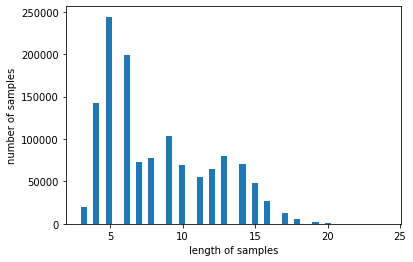

In [71]:
print("샘플의 최대 길이: ", max(len(sample) for sample in ner_sentences))
print("샘플의 평균 길이: ", np.mean([len(sample) for sample in ner_sentences]))

plt.hist([len(sample) for sample in ner_sentences],bins = 50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [72]:
max_len = max(len(sample) for sample in ner_sentences)
max_len

24

In [73]:
src_tokenizer = Tokenizer(oov_token = "OOV", lower = True) # 학습한 문자 이외의 것이 들어오면 OOV
tar_tokenizer = Tokenizer(lower = False)

src_tokenizer.fit_on_texts(ner_sentences)
tar_tokenizer.fit_on_texts(ner_tags)

In [74]:
tar_tokenizer.index_word

{1: 'O',
 2: 'I-SEA',
 3: 'B-SEA',
 4: 'B-PRI',
 5: 'I-HOT',
 6: 'B-INF',
 7: 'B-HOT',
 8: 'B-GRA',
 9: 'I-INF'}

In [75]:
vocab_size = len(src_tokenizer.index_word)+2 # zero_padding 및 OOV 추가로 인하여 +2
tag_size = len(tar_tokenizer.index_word) + 1 # zero_padding
print("단어 집합 크기:",vocab_size)
print("개체명 태그 집합 크기:", tag_size)

단어 집합 크기: 1340
개체명 태그 집합 크기: 10


In [76]:
X_data = src_tokenizer.texts_to_sequences(ner_sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [77]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [78]:
print(ner_sentences[0])
print(X_data[0])

['100000', '원', '아래', '로', '다현', '호스텔', '인천', '국제', '공항', '이용', '가능', '한', '방', '있', '어', '?']
[10, 16, 23, 24, 261, 110, 49, 45, 48, 7, 6, 8, 2, 4, 5, 3]


In [79]:
X_data = pad_sequences(X_data,maxlen=max_len,padding = "post")
y_data = pad_sequences(y_data,maxlen=max_len,padding = "post")

In [80]:
X_train,X_test, y_train,y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 1)

In [81]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [82]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1036529, 24)
y_train shape:  (1036529, 24, 10)
X_test shape:  (259133, 24)
y_test shape:  (259133, 24, 10)


In [83]:
path = "/content/gdrive/MyDrive/Colab Notebooks/"

In [ ]:
#saving ner_src_tokenizer
with open(path + "ner_src_tokenizer.picle",'wb') as handle:
  pickle.dump(src_tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [84]:
#saving ner_tar_tokenizer
with open(path + "ner_tar_tokenizer.picle",'wb') as handle:
  pickle.dump(src_tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

### 글자 임베딩(word_embedding) 데이터 전처리

In [85]:
#char_vocab 만들기
sequences = list(ner_df["tokenized_sample"].values)
chars = set(str.lower(char) for sequence in sequences for word in sequence for char in word)
chars = sorted(list(chars))
print(len(chars))

433


In [86]:
print(chars)

['&', '(', ')', ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '가', '간', '갈', '강', '갤', '거', '게', '견', '결', '경', '계', '고', '곡', '골', '곰', '곳', '공', '과', '곽', '관', '광', '교', '구', '국', '군', '굿', '궁', '귀', '그', '글', '금', '기', '길', '김', '까', '꽃', '꿀', '꿈', '꿔', '끄', '나', '낙', '날', '남', '내', '너', '널', '넘', '네', '넷', '녕', '노', '녹', '놈', '농', '높', '뉘', '뉴', '느', '는', '능', '니', '닉', '닝', '다', '단', '달', '담', '당', '대', '더', '덕', '던', '덤', '데', '델', '도', '독', '돋', '동', '됐', '두', '둔', '둥', '드', '들', '등', '디', '때', '떤', '뜰', '띠', '라', '랄', '랑', '래', '랜', '러', '럭', '럴', '럽', '레', '렉', '렌', '려', '로', '롯', '루', '룸', '르', '른', '를', '릉', '리', '린', '림', '립', '릿', '링', '마', '만', '맘', '매', '맥', '머', '먼', '멈', '메', '멕', '면', '명', '모', '몬', '몰', '몽', '무', '묵', '문', '물', '뭄', '뭐', '미', '민', '밀', '밍', '밑', '바', '박', '반', '방', '배', '백', '밸', '뱀', '버', '번', '벙', '베', '벡',

In [87]:
char_to_index = {c : i+2 for i,c in enumerate(chars)}
char_to_index["PAD"] = 0
char_to_index["OOV"] = 1

index_to_char = {}
for key,value in char_to_index.items():
  index_to_char[value] = key

In [88]:
print("단어 집합 최대 글자 길이: ",max(len(word) for sequence in sequences for word in sequence))
print("단어 집합 평균 글자 길이: ",np.mean([len(word) for sequence in sequences for word in sequence]))
max_len_char = max(len(word) for sequence in sequences for word in sequence)

단어 집합 최대 글자 길이:  13
단어 집합 평균 글자 길이:  2.1951828513409093


In [89]:
def integer_coding(sentences):
  char_data = []
  sentence_idx = -1
  for sentence in tqdm.tqdm_notebook(sentences):
    sentence_idx +=1
    word_to_indice = [word_to_index[str.lower(word)] for word in sentence]
    char_indice = [[char_to_index[str.lower(char)] for char in word] for word in sentence]
    char_indice = pad_sequences(sequences = char_indice, maxlen = max_len_char, padding = 'post', value = 0)

    cnt = 0
    cnt_char_indice = len(char_indice)
    for chars_of_tokens in char_indice:
      if len(chars_of_tokens) != max_len_char:
        continue 
      cnt +=1
    
    if cnt == cnt_char_indice: # sequence별로 각 word의 char 길이가 max_len_char과 같은 경우를 cnt한 다음, cnt 개수가 sequence의 word 개수와 같을 경우 append, 아니면 error문구 출력
      char_data.append(char_indice)
    else:
      print(f"{sentence_idx}번째 sequence의 char_paddding error")
  return char_data

In [93]:
X_char_data = integer_coding(sequences)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [94]:
print(sequences[0])

['100000', '원', '아래', '로', '다현', '호스텔', '인천', '국제', '공항', '이용', '가능', '한', '방', '있', '어', '?']


In [95]:
print([index_to_word[idx] for idx in X_data[0] if idx != 0])

['100000', '원', '아래', '로', '다현', '호스텔', '인천', '국제', '공항', '이용', '가능', '한', '방', '있', '어', '?']


In [96]:
X_data[0]

array([ 10,  16,  23,  24, 261, 110,  49,  45,  48,   7,   6,   8,   2,
         4,   5,   3,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [97]:
print(X_char_data[0])

[[  7   6   6   6   6   6   0   0   0   0   0   0   0]
 [298   0   0   0   0   0   0   0   0   0   0   0   0]
 [252 138   0   0   0   0   0   0   0   0   0   0   0]
 [148   0   0   0   0   0   0   0   0   0   0   0   0]
 [107 422   0   0   0   0   0   0   0   0   0   0   0]
 [425 244 383   0   0   0   0   0   0   0   0   0   0]
 [310 342   0   0   0   0   0   0   0   0   0   0   0]
 [ 66 325   0   0   0   0   0   0   0   0   0   0   0]
 [ 59 419   0   0   0   0   0   0   0   0   0   0   0]
 [309 292   0   0   0   0   0   0   0   0   0   0   0]
 [ 43 103   0   0   0   0   0   0   0   0   0   0   0]
 [415   0   0   0   0   0   0   0   0   0   0   0   0]
 [192   0   0   0   0   0   0   0   0   0   0   0   0]
 [314   0   0   0   0   0   0   0   0   0   0   0   0]
 [268   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   0   0   0   0   0   0   0   0]]


In [98]:
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value = 0)
X_char_data[0].shape

(24, 13)

In [99]:
print(X_char_data[0])

[[  7   6   6   6   6   6   0   0   0   0   0   0   0]
 [298   0   0   0   0   0   0   0   0   0   0   0   0]
 [252 138   0   0   0   0   0   0   0   0   0   0   0]
 [148   0   0   0   0   0   0   0   0   0   0   0   0]
 [107 422   0   0   0   0   0   0   0   0   0   0   0]
 [425 244 383   0   0   0   0   0   0   0   0   0   0]
 [310 342   0   0   0   0   0   0   0   0   0   0   0]
 [ 66 325   0   0   0   0   0   0   0   0   0   0   0]
 [ 59 419   0   0   0   0   0   0   0   0   0   0   0]
 [309 292   0   0   0   0   0   0   0   0   0   0   0]
 [ 43 103   0   0   0   0   0   0   0   0   0   0   0]
 [415   0   0   0   0   0   0   0   0   0   0   0   0]
 [192   0   0   0   0   0   0   0   0   0   0   0   0]
 [314   0   0   0   0   0   0   0   0   0   0   0   0]
 [268   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 

In [100]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size = 0.2, random_state = 1)

In [101]:
print("X_train shape: ", X_train.shape)
print("X_char_train shape: ", X_char_train.shape)
print("y_test shape: ", y_test.shape)
print("X_char_test shape: ", X_char_test.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1036529, 24)
X_char_train shape:  (1036529, 24, 13)
y_test shape:  (259133, 24, 10)
X_char_test shape:  (259133, 24, 13)
X_test shape:  (259133, 24)
y_test shape:  (259133, 24, 10)


### F1-Score

In [102]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        path = "/content/gdrive/MyDrive/Colab Notebooks/"
        self.model.save(path + 'ner_crf_best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

### 개체명 인식 모델 학습(BILSTM-CNN-CRF)

In [ ]:
#워드 임베딩
word_ids = Input(shape = (None,), dtype = "int32", name = "words_input")
# word_ids = Input(shape = (max_len,), dtype = "int32", name = "words_input")
word_embedding = Embedding(input_dim = vocab_size, output_dim = 128)(word_ids)

#char 임베딩
char_ids = Input(shape = (None, max_len_char,), name = 'char_input')
embed_char_ids = Embedding(input_dim = len(char_to_index), output_dim = 64)(char_ids)
dropout = Dropout(rate = 0.5)(embed_char_ids)

#char 임베딩에 대해서만 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(filters = 20, kernel_size = 3, strides = 1, padding = 'valid', activation='tanh'))(dropout)
maxpooling_out = TimeDistributed(GlobalMaxPooling1D())(conv1d_out)
char_embedding = TimeDistributed(Flatten())(maxpooling_out)
char_embedding = Dropout(rate = 0.5)(char_embedding)

#워드 임베딩과 char 임베딩 concat
output = concatenate(inputs = [word_embedding, char_embedding])

#BILSTM
output = Bidirectional(LSTM(256, return_sequences= True, dropout=0.5, recurrent_dropout=0.2))(output)

#CRF
output = TimeDistributed(Dense(units = 64, activation = "relu"))(output)
crf = CRF(units = tag_size)
output = crf(output)

model = Model(inputs = [word_ids, char_ids], output = output)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("cr...)`


In [ ]:
model.compile(optimizer = "adam", loss = crf.loss_function, metrics = [crf.accuracy])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [ ]:
history = model.fit(x = [X_train, X_char_train],y = y_train, epochs = 15, batch_size = 2048, callbacks = [F1score(use_char=True)],verbose = 1, validation_split = 0.1)

#현재 GPU 사용 제한으로 epoch 1인 상태에서 테스트 후 내일 다시 GPU를 사용하여 epoch = 15로 진행
# history = model.fit(x = [X_train, X_char_train],y = y_train, epochs = 1, batch_size = 2048, callbacks = [F1score(use_char=True)],verbose = 1, validation_split = 0.2)

Train on 932876 samples, validate on 103653 samples
Epoch 1/15
932876/932876 [==============================] - 100s 107us/step - loss: -0.0214 - crf_viterbi_accuracy: 0.9998 - val_loss: -0.0284 - val_crf_viterbi_accuracy: 0.9999
 - f1: 99.81
              precision    recall  f1-score   support

         GRA       1.00      0.82      0.90       109
         HOT       0.85      0.87      0.86       338
         INF       0.97      0.85      0.91       346
         PRI       1.00      1.00      1.00     22226
         SEA       1.00      1.00      1.00     53092

   micro avg       1.00      1.00      1.00     76111
   macro avg       0.96      0.91      0.93     76111
weighted avg       1.00      1.00      1.00     76111

f1_score improved from 0.000000 to 0.998069, saving model to best_model.h5
Epoch 2/15
932876/932876 [==============================] - 100s 107us/step - loss: -0.0356 - crf_viterbi_accuracy: 0.9999 - val_loss: -0.0434 - val_crf_viterbi_accuracy: 1.0000
 - f1: 99.94
  

### 모델 저장 및 로드

In [103]:
bilstm_cnn_CRF_model = load_model(filepath = path + "ner_crf_best_model.h5", custom_objects = {"CRF" : CRF,
                                                                                               "crf_loss" : crf_loss,
                                                                                               "crf_viterbi_accuracy" : crf_viterbi_accuracy})

In [104]:
i = 1034 # 확인하고 싶은 샘플의 인덱스
y_pred = bilstm_cnn_CRF_model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])
y_pred = np.argmax(y_pred,-1)
y_true = np.argmax(y_test[i],-1)

print(f"{'단어':15}|{'실제값':5}|{'예측값':5}")
for w,t, pred in zip(X_test[i], y_true, y_pred[0]):
  if w !=0:
    print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값  
아이니              : B-SEA   B-SEA
하우스              : I-SEA   I-SEA
속초설악파인리조트        : I-SEA   I-SEA
모레               : O       O
방                : O       O
있                : O       O
어                : O       O
?                : O       O


In [ ]:
#모든 샘픔의 결과 예측
y_pred = bilstm_cnn_CRF_model.predict([X_test, X_char_test])


KeyboardInterrupt: ignored

In [ ]:
f1score = F1score()
pred_tags = f1score.sequences_to_tags(sequences = y_pred)
test_tags = f1score.sequences_to_tags(sequences = y_test)

In [ ]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

         GRA       1.00      1.00      1.00       287
         HOT       1.00      1.00      1.00       799
         INF       1.00      1.00      1.00       831
         PRI       1.00      1.00      1.00     56027
         SEA       1.00      1.00      1.00    132807

   micro avg       1.00      1.00      1.00    190751
   macro avg       1.00      1.00      1.00    190751
weighted avg       1.00      1.00      1.00    190751



In [ ]:
print(f1_score(test_tags,pred_tags))

0.9999947575635252


### 토크나이저 저장 및 로드

In [ ]:
#saving
path = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(path+'ner_src_tokenizer.pickle','wb') as handle:
  pickle.dump(src_tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

with open(path+'ner_tar_tokenizer.pickle','wb') as handle:
  pickle.dump(tar_tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [105]:
#load
with open(path+'ner_src_tokenizer.pickle', 'rb') as handle:
    loaded_src_tokenizer = pickle.load(handle)

with open(path+'ner_tar_tokenizer.pickle', 'rb') as handle:
    loaded_tar_tokenizer = pickle.load(handle)

### 테스트

In [106]:
def ner_predict(sentence):
  new_sentence = mecab.morphs(sentence)
  #의도 분류 전처리
  new_sentence = mecab.morphs(sentence)
  encoded = loaded_src_tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded,maxlen = max_len, padding = "post")

  #개체명 인식 전처리
  char_to_indice = [[char_to_index[str.lower(char) if char in char_to_index else "OOV"] for char in word] for word in new_sentence]
  pad_new_char = pad_sequences(char_to_indice,maxlen = max_len_char, padding = "post")
  pad_new_char = np.array([pad_new_char])
  pad_new_char = pad_sequences(pad_new_char, maxlen = max_len, padding = "post")

  y_pred = bilstm_cnn_CRF_model.predict([pad_new,pad_new_char])
  y_pred = np.argmax(y_pred, axis = -1)

  print("{:15}|{:5}".format("단어", "예측값"))
  print(35 * "-")

  for w, pred in zip(new_sentence, y_pred[0]):
      if w != 0: # PAD값은 제외함.
          print("{:17}: {:7}".format(w, index_to_ner[pred]))

In [107]:
ner_predict("몬드리안 서울 이태원 퇴실 시간 언제야")

단어             |예측값  
-----------------------------------
몬드리안             : B-HOT  
서울               : I-HOT  
이태원              : I-HOT  
퇴실               : B-INF  
시간               : O      
언제               : O      
야                : O      


In [108]:
ner_predict("강서구 이용할수 있는 방 있어?")

단어             |예측값  
-----------------------------------
강서구              : B-SEA  
이용               : O      
할                : O      
수                : O      
있                : O      
는                : O      
방                : O      
있                : O      
어                : O      
?                : O      


In [109]:
ner_predict("신라호텔 반려견 동반 가능해?")

단어             |예측값  
-----------------------------------
신라호텔             : B-HOT  
반려견              : B-INF  
동반               : O      
가능               : O      
해                : O      
?                : O      


In [110]:
ner_predict("성산 근처 이용가능한 호텔")

단어             |예측값  
-----------------------------------
성산               : B-SEA  
근처               : O      
이용               : O      
가능               : O      
한                : O      
호텔               : O      


# 챗봇 구현

## 변경,취소,확인 질문

In [690]:
def get_service_center_info():
  #예약 사이트 연락처 url 및 header 지정
  url = "https://support.hotelscombined.co.kr/article/729-article"
  headers = {
      'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36',
      'Referer' : 'https://support.hotelscombined.co.kr/category/105-category'
  }

  #페이지 검색 with Beautiful soup
  req = Request(url = url, headers=headers)
  page = urlopen(req)
  html = page.read()
  soup = bs4.BeautifulSoup(html, 'html.parser')

  #페이지 검색 with lxml.html
  response = requests.get(url, stream=True)
  response.raw.decode_content = True
  tree = lxml.html.parse(response.raw)

  #서비스 센터명 가져오기
  for i in range(len(soup.select("td > a "))):
    print(f"[{i+1}번]: {soup.select('td > a')[i].text}")
  while True:
    center_number = input("서비스 센터 번호(1~17)를 입력해주세요")
    try:
      center_number = int(center_number)
      if center_number in range(1,18):
        break
    except:
      pass

  #예약 사이트 연락처 데이터 프레이 생성을 위한 데이터 가져오기
  service_center_list = [] #서비스센터명
  service_center_url_list = [] #서비스센터 페이지 url
  contact_address_list = [] #서비스센터 연락처
  mail_list = []  # 서비스 센터 이메일 주소
  remark_list = [] # 서비스 센터 참고사항

  i = center_number - 1
  #서비스 센터
  service_center = soup.select("td > a ")[i].text
  #서비스 센터 url 주소
  service_center_url = soup.select("td > a ")[i]['href']
  #서비스 센터 연락처
  contact_address = soup.select("td > strong")[i].text
  #서비스 센터 e메일 주소
  mail_xpath = f"//*[@id='fullArticle']/table/tbody/tr[{i+1}]/td[1]/text()"
  mail = " ".join(tree.xpath(mail_xpath)).replace("\xa0","").strip()
  #서비스 센터 참고 사항
  remark_xpath = f"//*[@id='fullArticle']/table/tbody/tr[{i+1}]/td[2]/text()"
  remark = " ".join(tree.xpath(remark_xpath)).replace("\xa0","").strip()

  print(f"{'서비스 센터명':20}: {service_center}")
  print(f"{'서비스 센터 url 주소':20}: {service_center_url}")
  print(f"{'서비스 연락처':20}: {contact_address}")
  print(f"{'서비스 이메일 주소':20}: {mail}")
  print(f"{'비고':20}: {remark}")


In [698]:
def answer_cancel_chage_confirmation():
  print("저희 호텔스 컴바인은 호텔 예약을 위한 가격 비교 서비스를 제공만을 하고 있습니다")
  print("따라서 예약 변경 / 예약 취소 / 예약 확인 / 결제 등은 예약 사이트로 연락주시거나 전달 받은 메일을 참고 부탁드립니다.")
  print("*"*150)
  answer = input("예약 사이트 정보가 필요하신가요? [y]/[n]")
  while True:
    if answer == "y":
      get_service_center_info()
      print("저희 호텔스 컴바인을 이용해주셔서 감사합니다.")
      break
    elif answer =="n":
      print("저희 호텔스 컴바인을 이용해주셔서 감사합니다.")
      break
    else:
      answer = input("[y] 또는 [n]을 입력해주세요")

## 초기 질문

In [702]:
def init_question():
  #질문 유형 입력
  # print(f"질문 유형을 선택해주세요 (1~4 번호입력) \n{'1. 예약 및 추천':8s}\n{'2. 변경/취소/확인':8s}\n{'3. 호텔 정보 검색':8s}\n{'4. 자유 질문':8s}")

  #입력한 질문 유형 확인
  while True:
    question_type = input(f"질문 유형을 선택해주세요 (1~4 번호입력) \n{'1. 예약 및 추천':8s}\n{'2. 변경/취소/확인':8s}\n{'3. 호텔 정보 검색':8s}\n{'4. 자유 질문':8s}\n답변: ")
    try: #질문 유형이 숫자형이고, 1,2,3,4 번 내에 있을 경우 while문 끝내기 / 아닐 경우 재질문
      question_type = int(question_type)
      if question_type in [1,2,3,4]: 
        break
      else:
       print("잘못된 유형을 선택하셨습니다. 1~4번 중 번호 하나를 입력해 주세요") 
    except:
      print("잘못된 유형을 선택하셨습니다. 1~4번 중 번호 하나를 입력해 주세요")

  if question_type == 4: #자유 질문일 경우
    print("저희 호텔스컴바인 이용 관련 상담을 도와드리겠습니다.\n궁금하신 사항을 입력해 주세요")
    question = input("")
    question_type_name = predict(question)

    if question_type_name =="예약":
      question_type = 1
    elif question_type_name =="정보":
      question_type = 3
    else: #변경 / 취소 / 확인
      question_type = 2

  
  if question_type == 1: # 예약 및 추천 관련 질문일 경우
    search = input("호텔명이나 지역명을 입력해주세요\n답변: ")
  elif question_type == 2: # 변경/취소/확인 관련 질문일 경우
    answer_cancel_chage_confirmation()
    
  else: #호텔 정보 검색 관련 질문일 경우
    hotel = input("호텔명을 입력해주세요\n답변: ")




  

  # return question
init_question()

질문 유형을 선택해주세요 (1~4 번호입력) 
1. 예약 및 추천
2. 변경/취소/확인
3. 호텔 정보 검색
4. 자유 질문
답변: 1
호텔명이나 지역명을 입력해주세요
답변: 신라 호텔
